In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
import time
import math
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from pandas.plotting import parallel_coordinates
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA


In [2]:
InteractiveShell.ast_node_interactivity = "all"


In [3]:
# Design

# Sizes

title_size = 50
tick_size = 30
text_size = 30

# Colors

palette_max_8 = {
    0: '#1b0c41',
    1: '#4a0c6b',
    2: '#781c6d',
    3: '#a52c60',
    4: '#cf4446',
    5: '#ed6925',
    6: '#fb9b06',
    7: '#f7d13d'
}

palette_max_5 = {
    0: '#fbb61a',
    1: '#ed6925',
    2: '#ba3655',
    3: '#781c6d',
    4: '#320a5e'
}

sns.color_palette('inferno_r', 5)


[(0.986175, 0.713153, 0.103863),
 (0.929644, 0.411479, 0.145367),
 (0.729909, 0.212759, 0.333861),
 (0.472328, 0.110547, 0.428334),
 (0.197297, 0.0384, 0.367535)]

In [4]:
# Functions


def plot_correlation_circle(pc1, pc2, columns, pc1_name, pc2_name):

    """Plots the correlation circle of given principal components"""

    fig, ax = plt.subplots(figsize=(12, 12))

    for i, (x, y) in enumerate(zip(pc1, pc2)):

        plt.plot([0, x], [0, y], color='k', alpha=0.5)
        plt.text(x, y, columns[i], fontsize='14')

    ax.add_patch(plt.Circle((0, 0), 1,
                            fill = False,
                            color=sns.color_palette('icefire')[0]))

    ax.plot([-1, 1], [0, 0], color=sns.color_palette('icefire')[0], ls='--')
    ax.plot([0, 0], [-1, 1], color=sns.color_palette('icefire')[0], ls='--')

    ax.set_xlabel('{}'.format(pc1_name), fontsize=text_size)
    ax.set_ylabel('{}'.format(pc2_name), fontsize=text_size)

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])

    ax.tick_params(labelsize=tick_size)

    plt.title('Principal Component Circle', fontsize=title_size, pad=30)

    plt.show();


def plot_pca_projected(data, x, y, model, hue, palette):

    """Plots the PCA projected data"""

    fig, ax = plt.subplots(figsize=(10, 10))

    sns.scatterplot(
        data=data,
        x=x,
        y=y,
        hue=hue,
        palette=palette,
        ax=ax)

    ax.tick_params(labelsize=tick_size)
    ax.set_xlabel('{}'.format(x), fontsize=text_size)
    ax.set_ylabel('{}'.format(y), fontsize=text_size)

    plt.axis('square')

    plt.title('{} Clusters'.format(model), pad=20, fontsize=title_size)

    plt.show();


In [5]:
# Imports dataframe

cleaned_df = \
    pd.read_csv(r'F:\Data\Projet 5\Livrables\cleaned_data')

# Seed for random states

seed = 34


<center><h6>Feature Engineering : Why not keep Frequency

In [6]:
# Creates a dataframe with frequent customers

frequent_customers_df = cleaned_df[cleaned_df['Frequency'] > 1].copy()


    Frequency is mostly used to express Loyalty but : 

    (Considering that frequent customers represent around 3% of total customers)

In [7]:
(frequent_customers_df.shape[0]/cleaned_df.shape[0])*100


2.975869579281047

    25% (the first quartile) of frequent customers made several orders but the           same day, never coming back later on 

In [8]:
# Computes the distance in days between the first and last order passed

frequent_customers_df['order_purchase_timestamp_distance'] = \
    (pd.to_datetime(frequent_customers_df['order_purchase_timestamp_max'])
     - pd.to_datetime(frequent_customers_df['order_purchase_timestamp_min']))\
    .dt.days

# Displays the value in days of the first quartile of
# order_purchase_timestamp_distance distribution

frequent_customers_df['order_purchase_timestamp_distance'].describe()['25%']


0.0

     Moreover 90% of the total of frequent customers have made 2 orders.
     2 orders with the same brand isn't an obvious sign of brand loyalty 

In [9]:
frequent_customers_df['Frequency']\
    .value_counts(normalize = True)\
    .mul(100)\
    .reset_index()\
    .rename({'index': 'Number of orders',
             'Frequency': 'Percent of total frequent customers'},
            axis=1)


Number of orders  Percent of total frequent customers
0                 2                            91.956522
1                 3                             6.340580
2                 4                             1.014493
3                 5                             0.326087
4                 6                             0.181159
5                 7                             0.108696
6                 9                             0.036232
7                15                             0.036232

    One might also consider that Olist isn't a marketplace. 
    It appears on digital marketplaces as a vendor. 
    In other word, in the user experience Olist isn't necesseraly recognized by the
    customer. 
    For instance on Amazon one might not see that he bought an item through Olist and
    would say : 'I have bought on Amazon x object'. 
    
    Therefore several orders with Olist could be due to luck. 
    On 2 years of data, one might buy two articles whith Olist as a vendor without
    paying attention to Olist name/brand. 
    Such case obviously doesn't communicates loyalty to Olist brand.
    
    Around 30% of frequent customers have made more than one order in the same 
    seller which can suggest a more powerful influence from the couple 
    (product, seller) rather than the vendor (Olist)

In [10]:
# Returns True if seller_id_mode was an array e.g : '[' symbol
# which implies the commands wasn't passed trhough a same seller

# The fact that 2 commands were passed through different sellers could
# suggest Olist influence (fidelity)

# The reverse could rather suggest not Olist influence but the couple
# product-seller influence (seller not vendor)

frequent_customers_df['seller_id_mode']\
    .apply(lambda x: True if re.compile('\[').search(x) else False)\
    .value_counts(normalize=True)\
    .mul(100)\
    .to_frame(name='The orders doesn\'t come from the same seller ? (%)')


The orders doesn't come from the same seller ? (%)
True                                           70.072464 
False                                          29.927536

    As frequency wasn't kept (for the above reasons) the monetary indicator 
    have been engineered not with the sum of amount spent but with the mean 
    so 'frequent' customers don't 'wrongly' appear in customers that spend a lot 
    cluster.

<center><h6>X

In [11]:
# RFM TAE

rms_tae_columns = [
    'Recency',
    'Monetary_Mean',
    'Satisfaction',
    'Timing',
    'Basket',
    'Event']

X = cleaned_df[rms_tae_columns].copy()

X.head()


Recency  Monetary_Mean  Satisfaction  Timing  Basket       Event
0    -1426         141.90           5.0    -5.0     1.0   58.294444
1    -1429          27.19           4.0    -5.0     1.0  144.738889
2    -1852          86.22           3.0    -2.0     1.0   14.466667
3    -1636          43.62           4.0   -12.0     1.0  -28.505556
4    -1603         196.89           5.0    -8.0     1.0   -4.516667

<center><h6>Preprocessing

In [12]:
# Reciproqual transformation for left skewed distributions

# NB : when applying reciproqual transformation, datas are first inverted
# This cancell the inversion caused by recriproqual transformation

X['Recency'] = 1/(-X[['Recency']])
X['Satisfaction'] = 1/(X[['Satisfaction']]).apply(lambda x: 6 - x)

# Logarithmic transformation for right skewed distributions

X[['Basket', 'Monetary_Mean']] = np.log1p(X[['Basket', 'Monetary_Mean']])

# StandardScale the data

X_std = StandardScaler().fit_transform(X)

X_std = pd.DataFrame(data=X_std, columns=X.columns)


<center><h6>Dimensionality Reduction (for visualisation only)

In [13]:
# PCA on max number of components

X_std_pca = PCA(n_components=6).fit(X_std[rms_tae_columns])

# Computes the projection of the data in a new dataframe

X_std_pca_projected = pd.DataFrame(X_std_pca.transform(X_std[rms_tae_columns]))

X_std_pca_projected = \
    X_std_pca_projected.rename({0: 'PC1', 1: 'PC2', 2: 'PC3',
                                3: 'PC4', 4: 'PC5', 5: 'PC6'},
                               axis=1)

components_name = X_std_pca_projected.columns.tolist()

X_std_pca_projected.head()


PC1       PC2       PC3       PC4       PC5       PC6
0  0.478658 -0.630615 -1.134782 -0.052048  0.624913  0.445916
1  1.498092 -2.146134 -0.451469 -0.844293 -1.290065 -0.429040
2  0.578861 -0.206261  2.172395 -0.896446  0.254990 -0.023825
3 -0.430423 -0.505839  1.434871  0.291140 -0.617093 -0.137725
4 -0.415062  0.258500 -0.053451 -0.139087  1.074324  0.572271

In [14]:
# Creates a dataframe to analyse the explained variace of the above PCA

X_std_pca_df = \
    pd.DataFrame(data=np.c_[X_std_pca.explained_variance_ratio_,
                            np.cumsum(X_std_pca.explained_variance_ratio_)],
                 columns=['Explained_variance',
                          'Cumulative_explained_variance'])

X_std_pca_df


Explained_variance  Cumulative_explained_variance
0            0.219355                       0.219355
1            0.208901                       0.428256
2            0.179092                       0.607348
3            0.144790                       0.752138
4            0.130187                       0.882325
5            0.117675                       1.000000

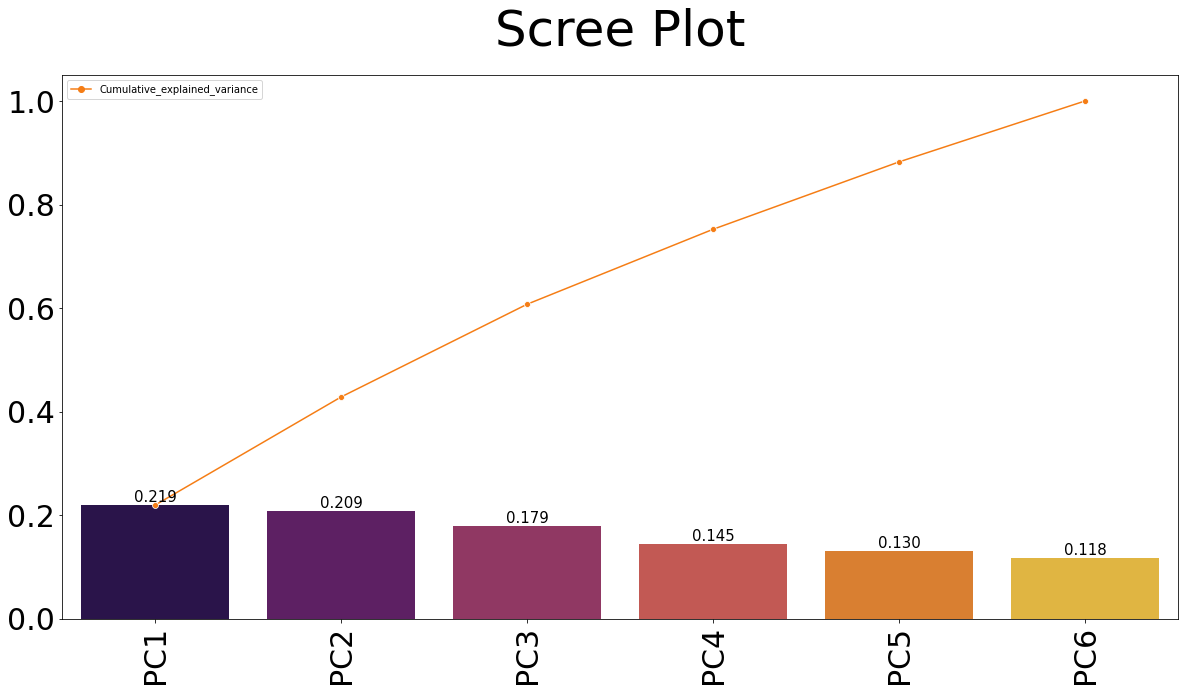

In [15]:
# Plots the PCA's scree plot

fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=X_std_pca_df[['Cumulative_explained_variance']],
             markers=True,
             palette=[sns.color_palette("inferno")[4]])

sns.barplot(data=X_std_pca_df[['Explained_variance']].T,
            palette=sns.color_palette('inferno', 6),
            ax=ax)

ax.set_xticklabels(['PC' + str(i + 1) for i in range(X_std_pca_df.shape[0])],
                   rotation=90)

ax.bar_label(
    ax.containers[0],
    fmt='%.3f',
    **{'size': 15})

ax.legend(loc='upper left')
ax.tick_params(labelsize=tick_size)
plt.title('Scree Plot', fontsize=title_size, pad=30)
plt.show();


<p class="anchor" id="PCA_Circles"></p>

* [Anchor to Kmeans's PCA ](#PCA_Kmeans)
* [Anchor to DBSCAN's PCA ](#PCA_DBSCAN)
* [Anchor to Hierarchcal's PCA ](#PCA_hierarchical)

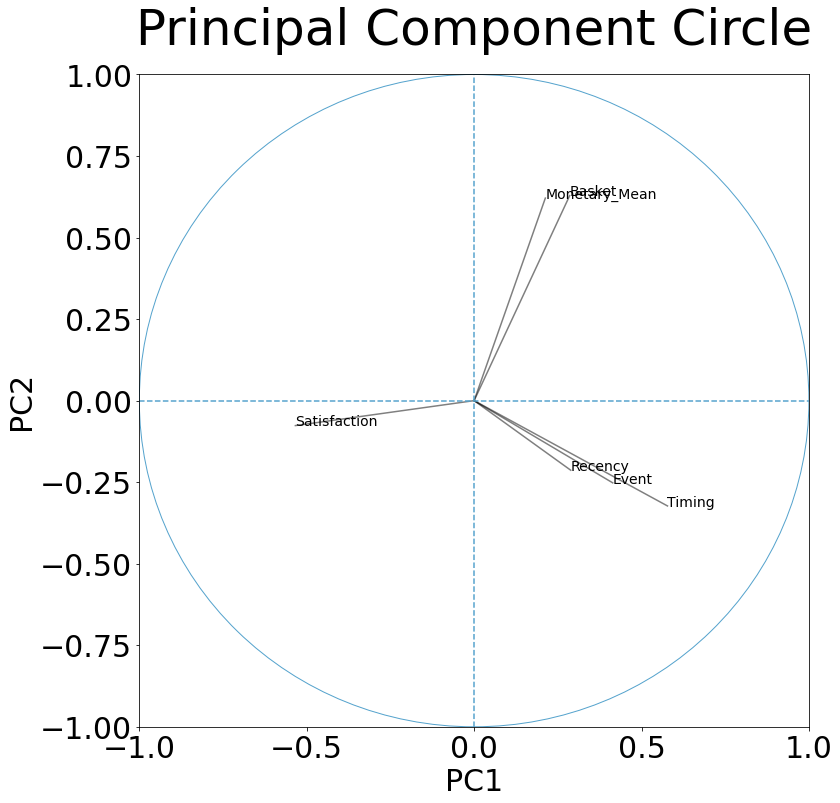

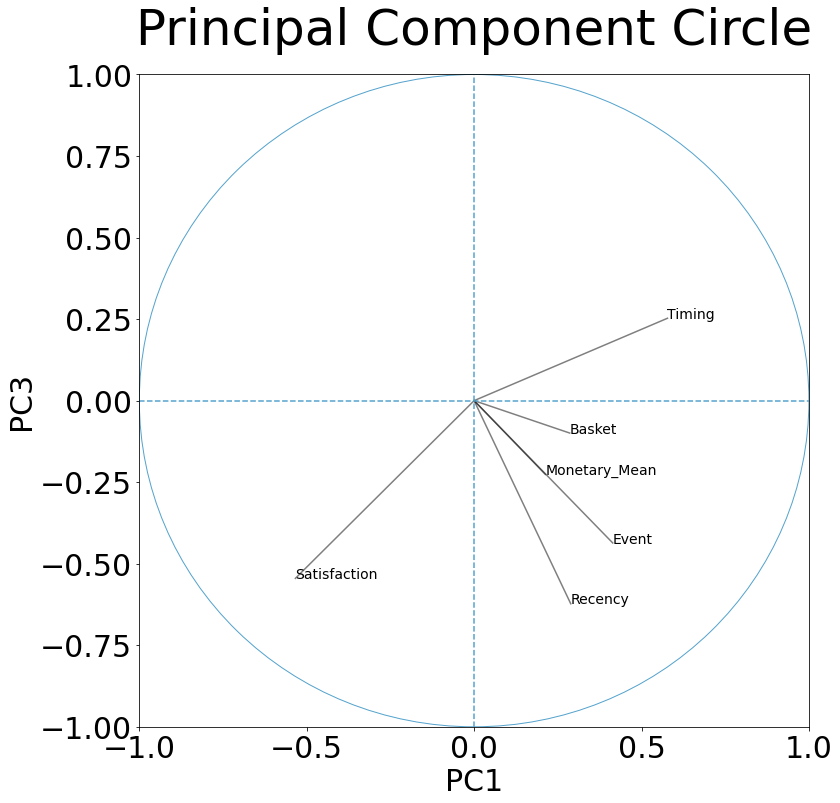

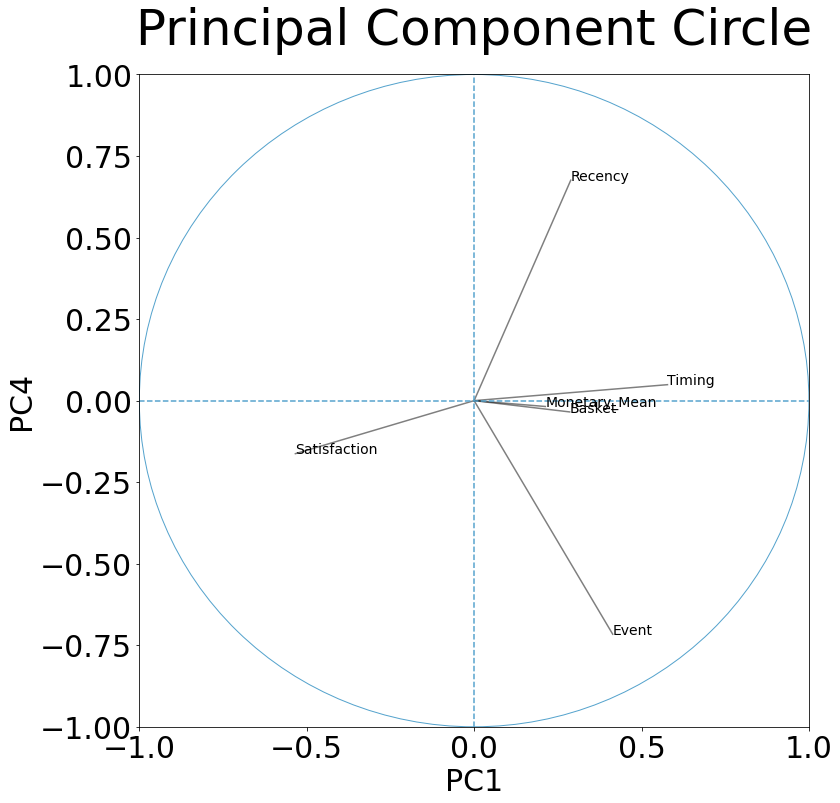

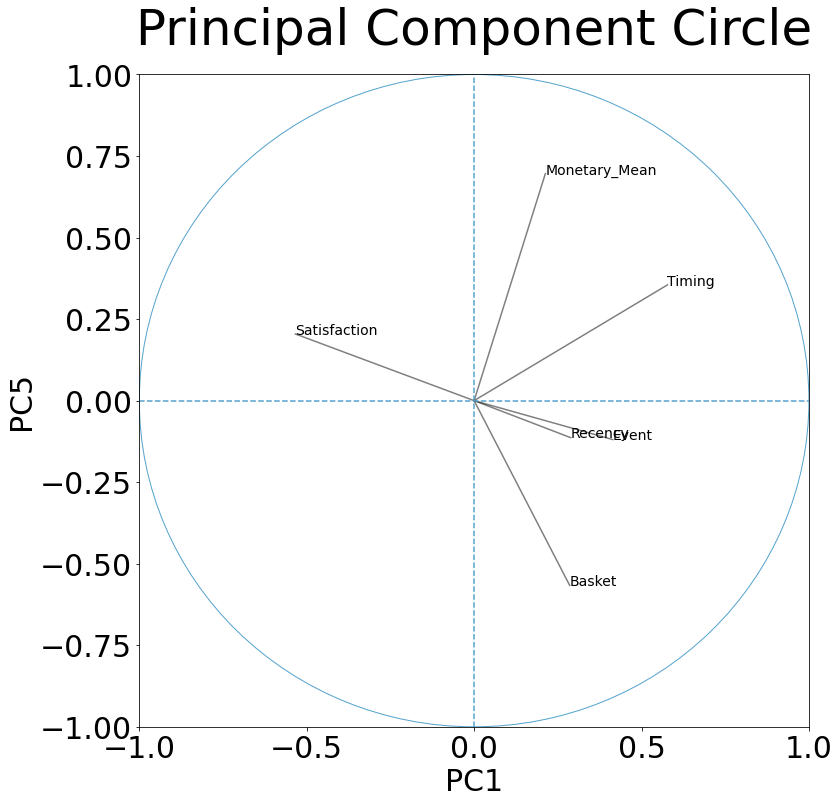

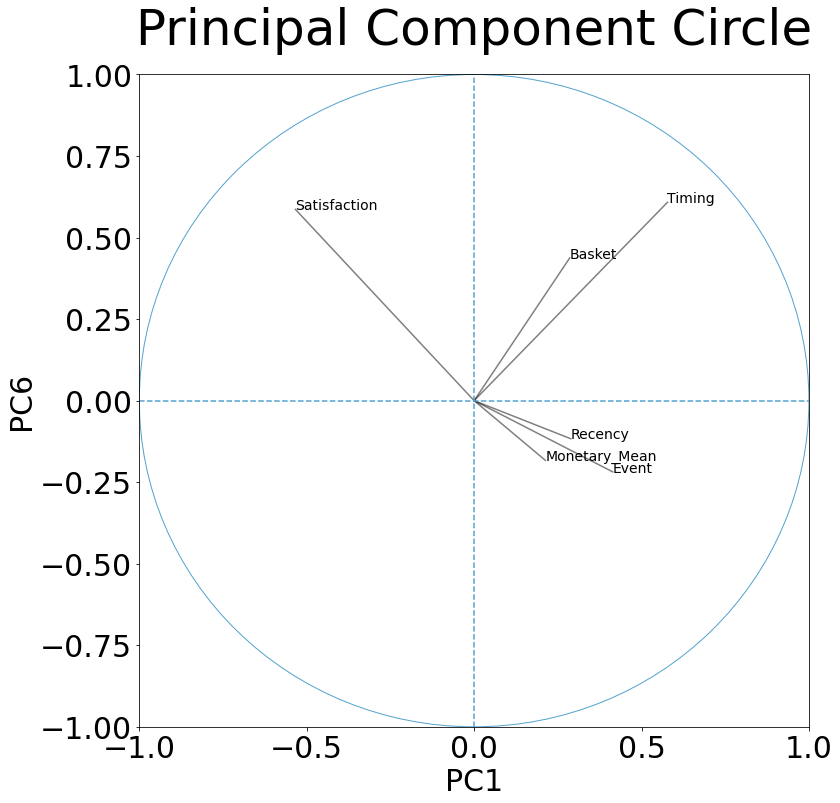

In [16]:
# Plots the correlation circles of the above PCA

# N.B : One can find above anchors to make back and forth analysis with
# projected data with clusters

plot_correlation_circle(X_std_pca.components_[0, :],
                        X_std_pca.components_[1, :],
                        X_std.columns,
                        'PC1',
                        'PC2')

plot_correlation_circle(X_std_pca.components_[0, :],
                        X_std_pca.components_[2, :],
                        X_std.columns,
                        'PC1',
                        'PC3')

plot_correlation_circle(X_std_pca.components_[0, :],
                        X_std_pca.components_[3, :],
                        X_std.columns,
                        'PC1',
                        'PC4')

plot_correlation_circle(X_std_pca.components_[0, :],
                        X_std_pca.components_[4, :],
                        X_std.columns,
                        'PC1',
                        'PC5')

plot_correlation_circle(X_std_pca.components_[0, :],
                        X_std_pca.components_[5, :],
                        X_std.columns,
                        'PC1',
                        'PC6')


<center><h3>Kmeans (chosen model in RMS TAE)

In [17]:
# Creates an empty dataframe for computation logs

kmeans_scores_df = pd.DataFrame(data=[])

# Computes inertia, silhouette score and fit-time for k selection

# NB : The range is in a [3;9] range as k-clusters > 9 would be too much
# and < 3 not enough

for i in range(3, 10):

    t0 = time.time()

    kmeans = KMeans(n_clusters=i, random_state=seed)\
        .fit(X_std[rms_tae_columns])

    fit_time = time.time() - t0

    # Commits params and scores in kmeans_scores_df
    kmeans_scores_df.loc[i, 'clusters'] = i

    kmeans_scores_df.loc[i, 'inertia'] = kmeans.inertia_

    kmeans_scores_df.loc[i, 'silhouette'] = \
        silhouette_score(X_std, kmeans.labels_)

    kmeans_scores_df.loc[i, 'fit_time'] = fit_time


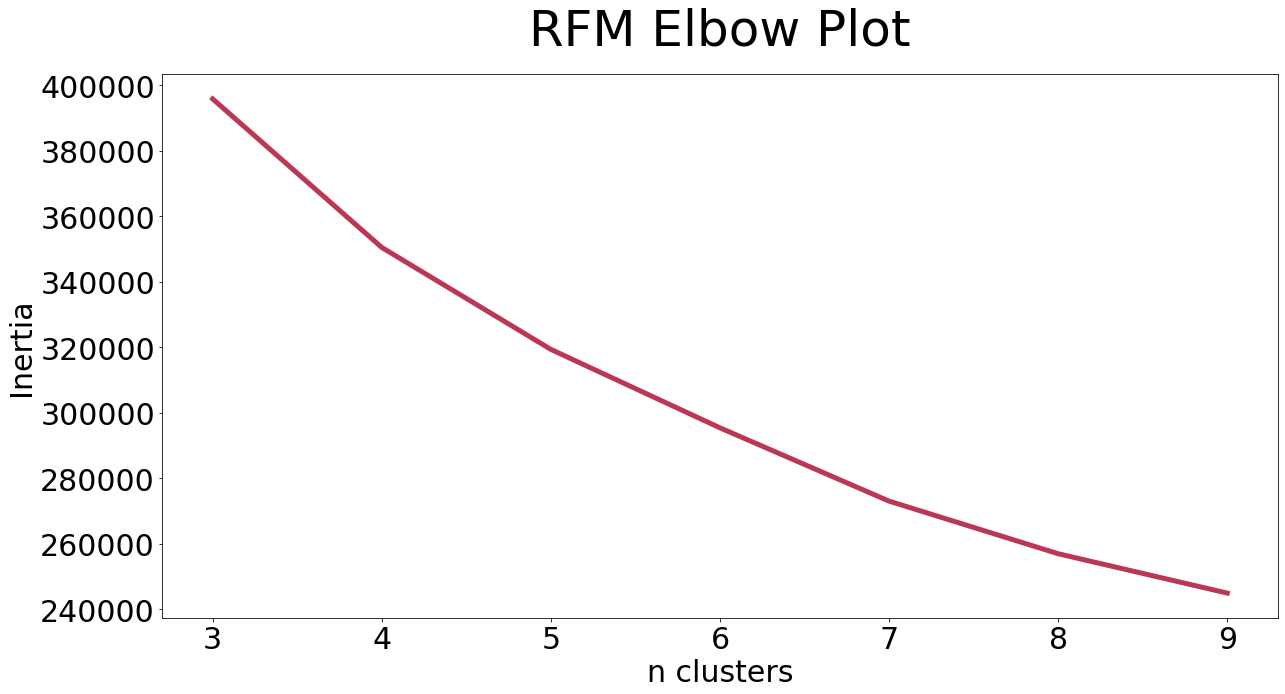

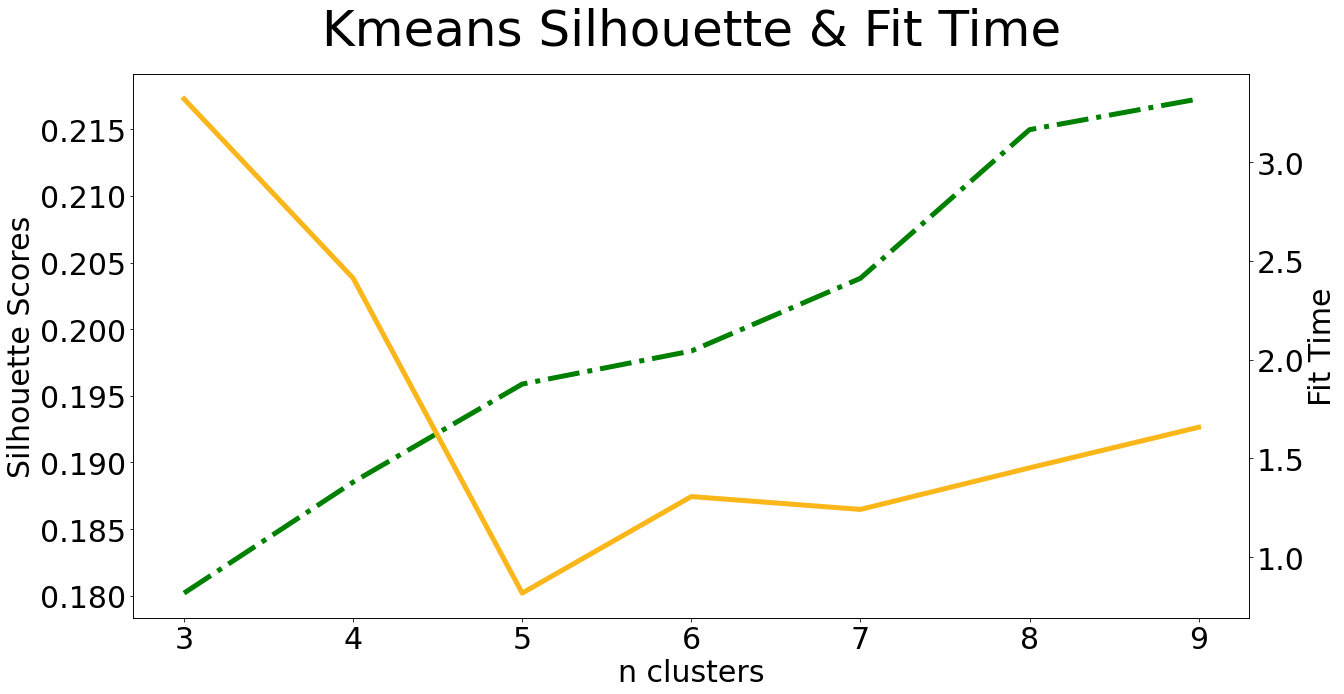

In [18]:
# Plots results

# Elbow Plot

fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=kmeans_scores_df,
             x='clusters',
             y='inertia',
             color=sns.color_palette('inferno', 5)[2],
             lw=5)

ax.tick_params(labelsize=tick_size)
ax.set_xlabel('n clusters', fontsize=text_size)
ax.set_ylabel('Inertia', fontsize=text_size)

plt.title('RFM Elbow Plot', fontsize=title_size, pad=30)
plt.show();


# Silhouette & Fit time plots

fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

sns.lineplot(data=kmeans_scores_df,
             x='clusters',
             y='silhouette',
             lw=5,
             color=sns.color_palette('inferno', 5)[4],
             ax=ax1)

sns.lineplot(data=kmeans_scores_df,
             x='clusters',
             y='fit_time',
             lw=5,
             color='green',
             ax=ax2,
             ls='dashdot')

ax1.set_zorder(1)
ax1.patch.set_visible(False)
ax1.tick_params(labelsize=tick_size)
ax1.set_xlabel('n clusters', fontsize=text_size)
ax1.set_ylabel('Silhouette Scores', fontsize=text_size)

ax2.tick_params(labelsize=tick_size)
ax2.set_ylabel('Fit Time', fontsize=text_size)

plt.title('Kmeans Silhouette & Fit Time', fontsize=title_size, pad=30)

plt.show();


    8-Means have been chosen.
    
    The choice tend to consider the 'discriminative power' of the number of clusters.
    With 6 Means, not all the features are used to differenciate the segments.
    
    8-Means is the minimum number of clusters that allows each features to have a         'discriminative power' (this will be observed through the parallel plot)
    
    8-Means have been priviledged over 9 Means for the fit-time as well as for the       size of resulting clusters 

In [19]:
# Fits a 8-Means

kmeans_8 = \
    KMeans(n_clusters=8, random_state=seed).fit(X_std[rms_tae_columns])

X_std['kmeans_labels'] = kmeans_8.labels_

X_std_pca_projected['kmeans_labels'] = X_std['kmeans_labels'].values


In [20]:
# Creates a dataframe with kmeans's centroids

X_std_centroids = \
    pd.DataFrame(kmeans_8.cluster_centers_,
                 columns=rms_tae_columns)

X_std_centroids['cluster'] = \
    X_std_centroids.index

X_std_centroids.head()


Recency  Monetary_Mean  Satisfaction    Timing    Basket     Event  \
0  0.705753      -0.479001      0.807304 -0.148034 -0.297109 -0.352092   
1 -1.017283      -0.212087     -1.077836 -0.154200 -0.294266 -0.341258   
2  0.690224      -0.262197     -1.082063 -0.061656 -0.292558 -0.161399   
3  0.088718       1.505008      0.514099 -0.305418 -0.295593 -0.197909   
4 -0.013265       0.666739     -0.317869 -0.186892  2.815990 -0.068535   

   cluster  
0        0  
1        1  
2        2  
3        3  
4        4

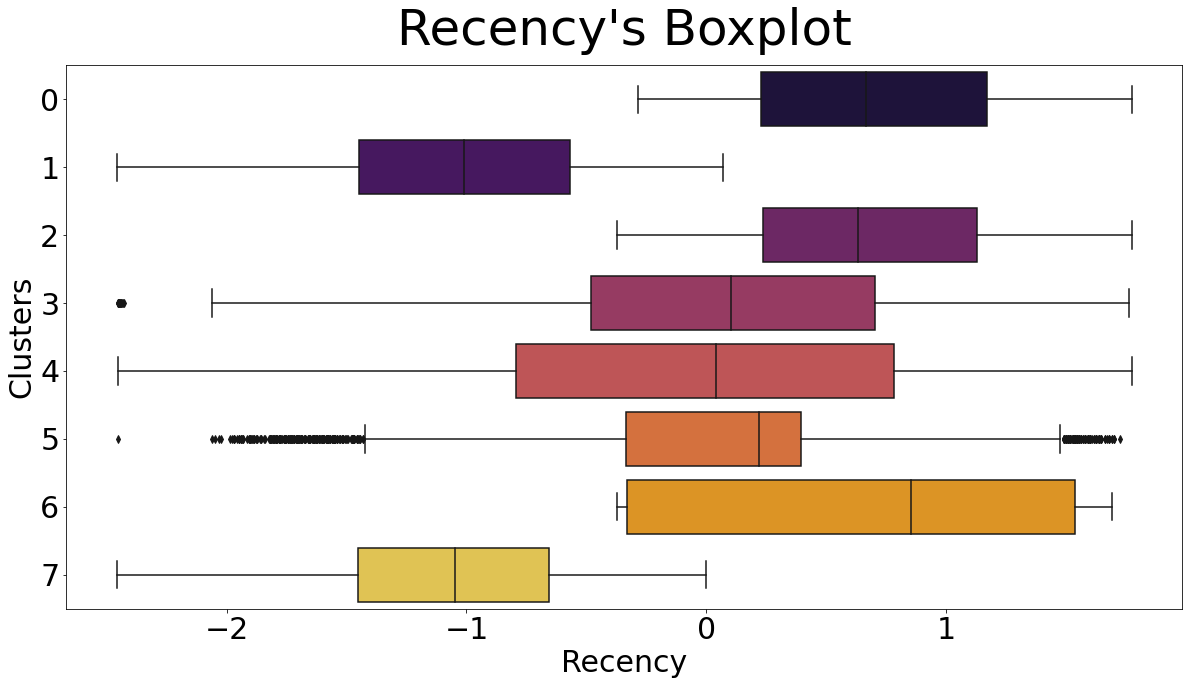

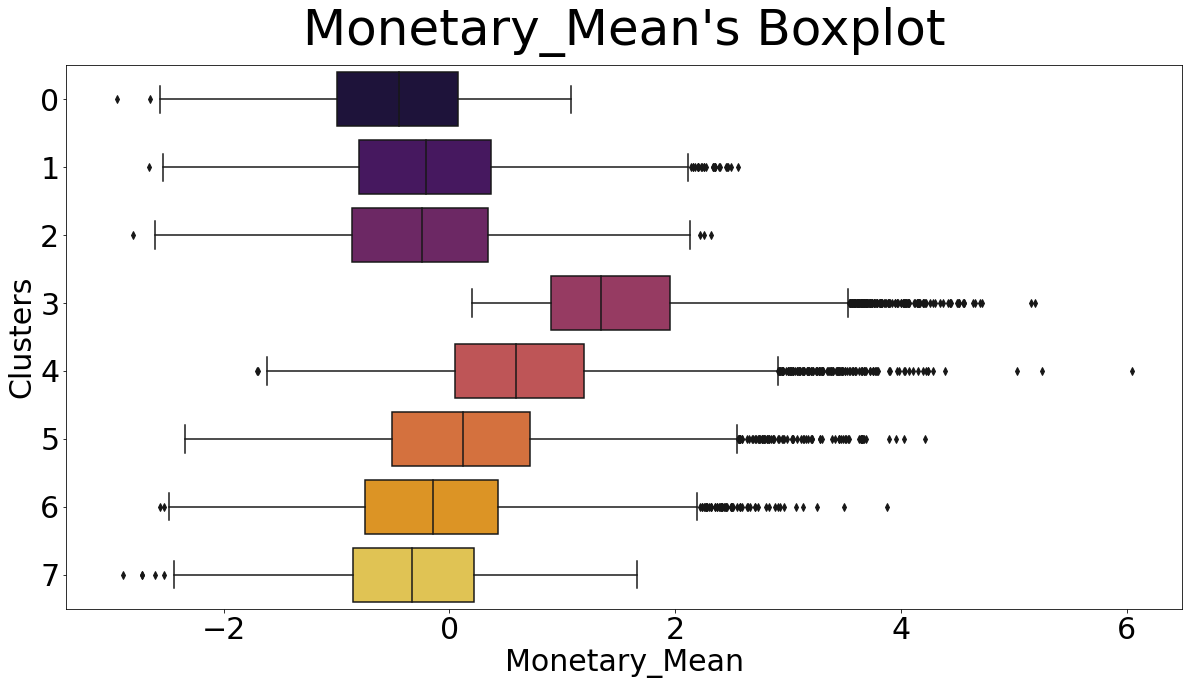

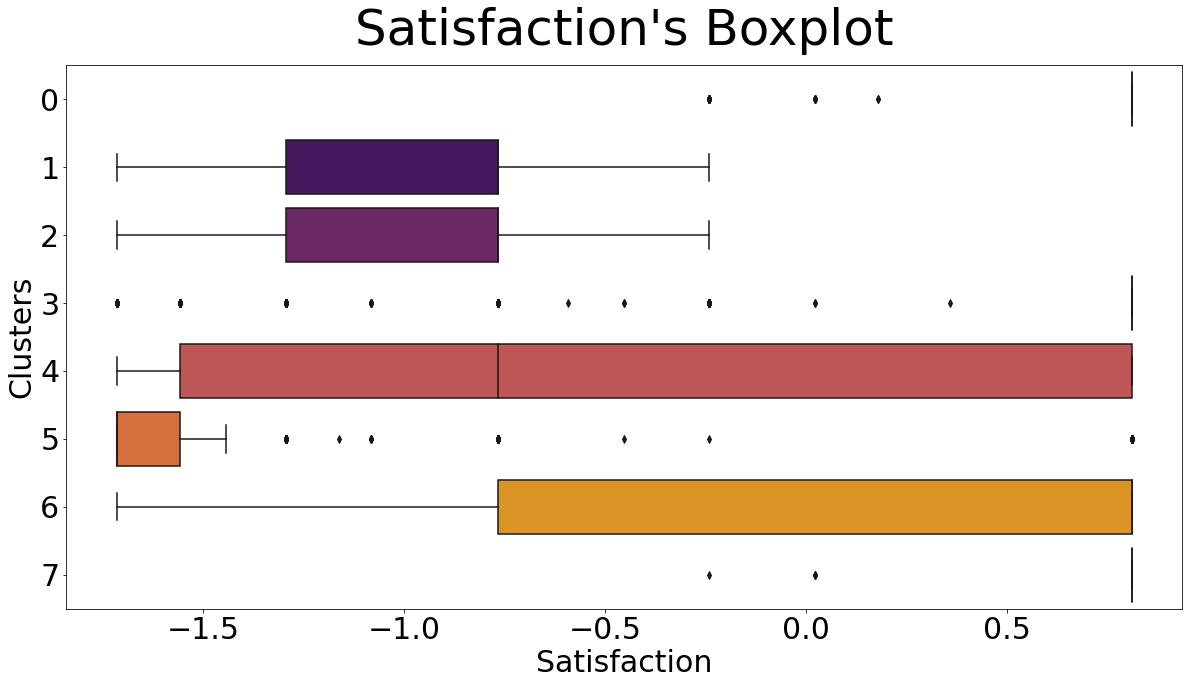

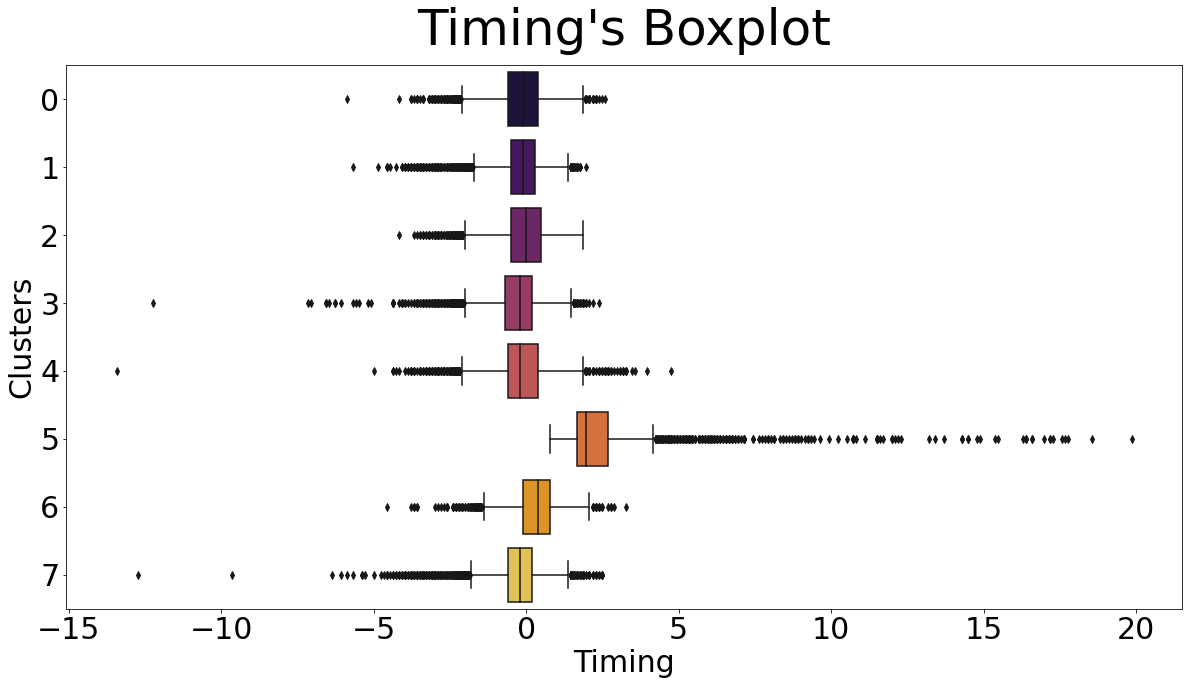

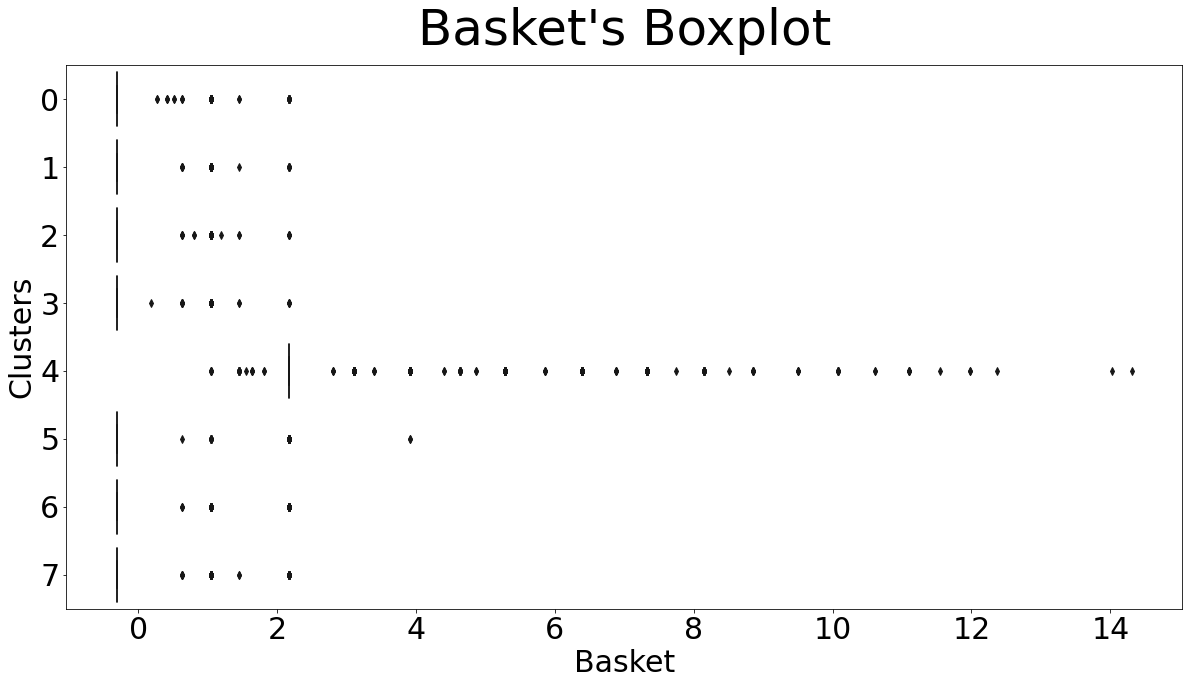

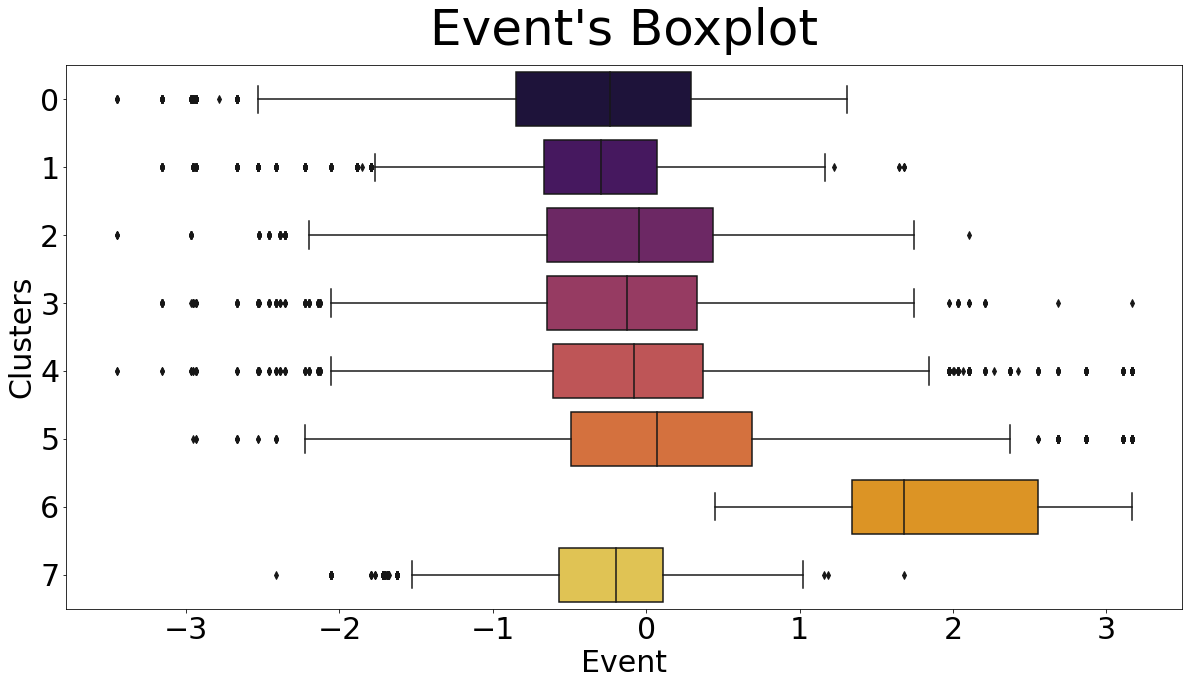

In [21]:
# Plots cluster's boxplots

for i in rms_tae_columns:

    fig, ax = plt.subplots(figsize=(20, 10))

    sns.boxplot(data=X_std[rms_tae_columns + ['kmeans_labels']],
                x=i,
                y='kmeans_labels',
                palette=palette_max_8,
                orient="h",
                ax=ax)

    ax.tick_params(labelsize=tick_size)
    ax.set_xlabel('{}'.format(i), fontsize=text_size)
    ax.set_ylabel('Clusters', fontsize=text_size)
    plt.title('{}\'s Boxplot'.format(i), pad=20, fontsize=title_size)

plt.show();


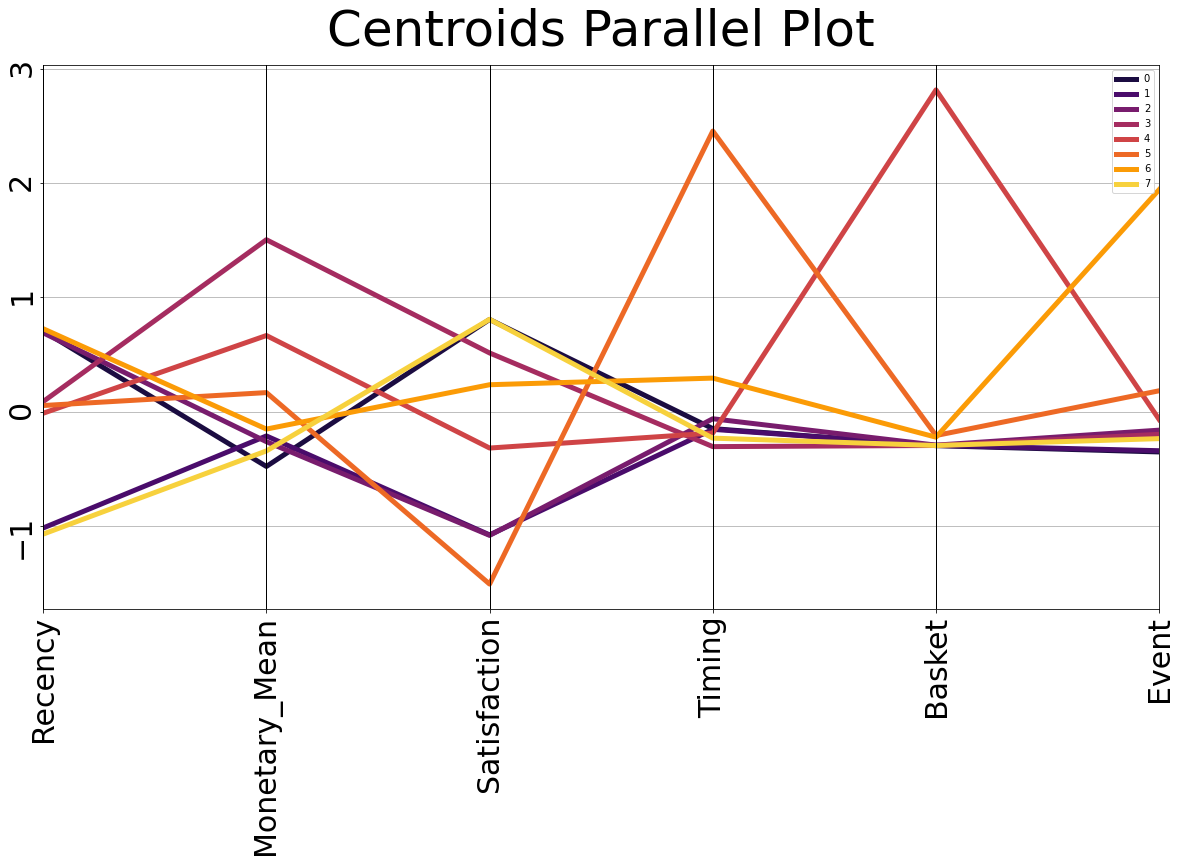

In [22]:
# Parrallel plots the centroids of the 4Means

fig, ax = plt.subplots(figsize=(20, 10))

parallel_coordinates(X_std_centroids,
                     'cluster',
                     color=palette_max_8.values(),
                     ax=ax,
                     lw=5)

ax.tick_params(labelsize=tick_size, rotation=90)

plt.title('Centroids Parallel Plot', pad=20, fontsize=title_size)
plt.show();


    One can see, isolating TBE and RMS, the discriminative power of each feature :

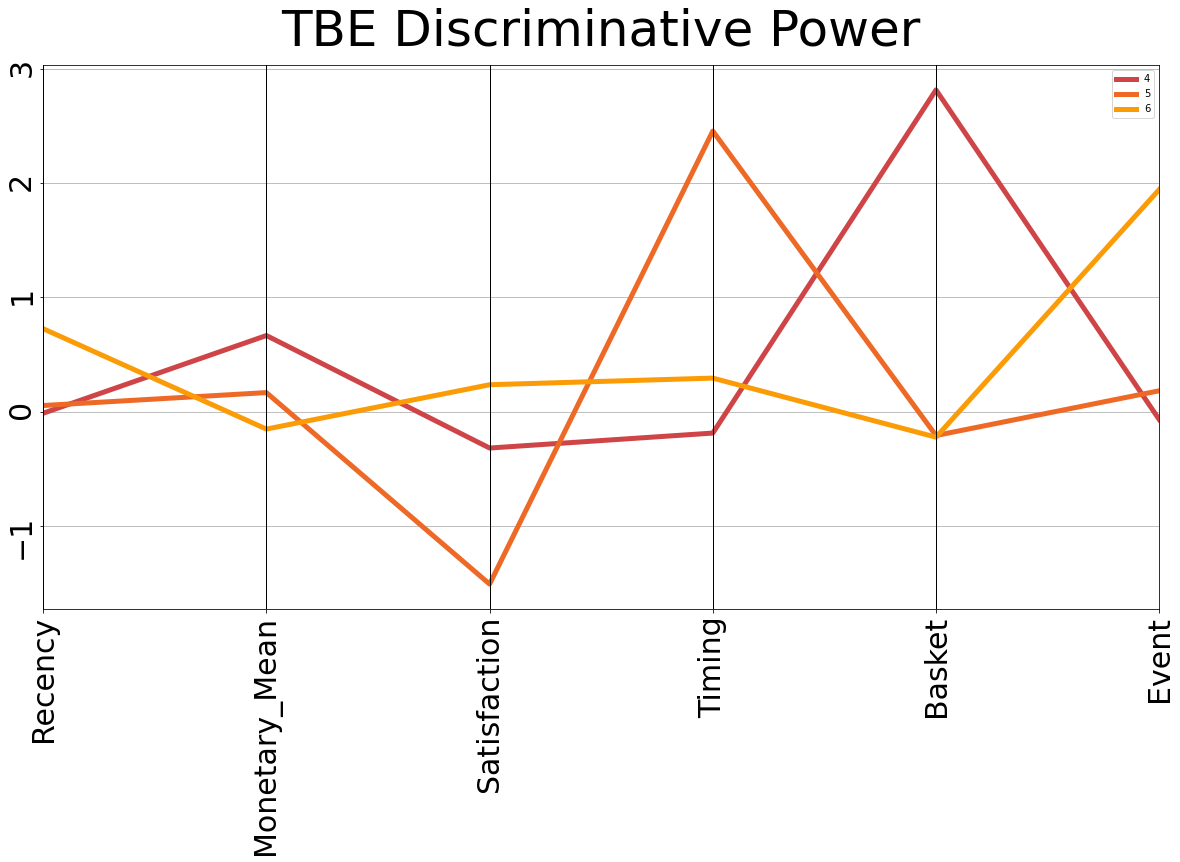

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))

parallel_coordinates(X_std_centroids[X_std_centroids['cluster']
                                     .isin([4, 5, 6])],
                     'cluster',
                     color=[palette_max_8[4],
                            palette_max_8[5],
                            palette_max_8[6]],
                     ax=ax,
                     lw=5)

ax.tick_params(labelsize=tick_size, rotation=90)

plt.title('TBE Discriminative Power', pad=20, fontsize=title_size)
plt.show();


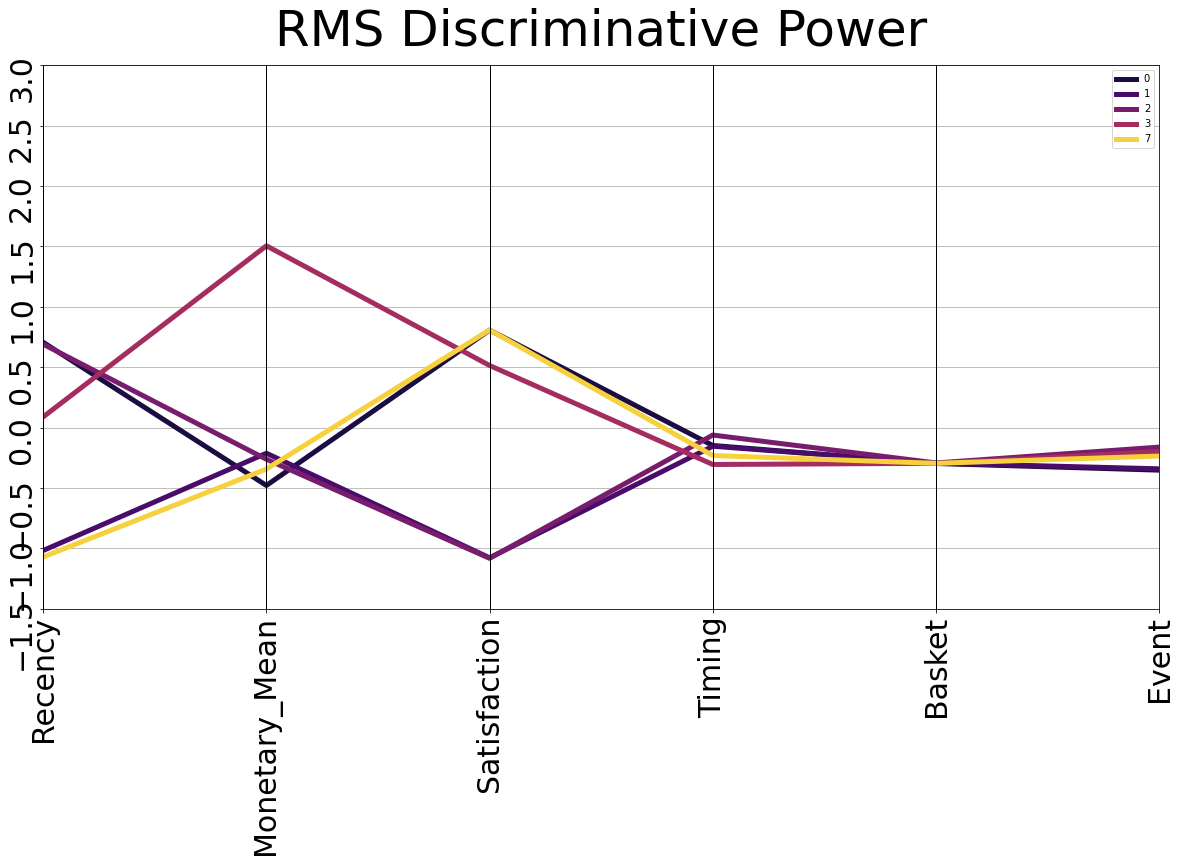

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))

parallel_coordinates(X_std_centroids[~X_std_centroids['cluster']
                                     .isin([4, 5, 6])],
                     'cluster',
                     color=[palette_max_8[0],
                            palette_max_8[1],
                            palette_max_8[2],
                            palette_max_8[3],
                            palette_max_8[7]],
                     ax=ax,
                     lw=5)

ax.tick_params(labelsize=tick_size, rotation=90)
ax.set_ylim(-1.5, 3)

plt.title('RMS Discriminative Power', pad=20, fontsize=title_size)
plt.show();


* [Anchor to PCA Circles](#PCA_Circles)


<p class="anchor" id="PCA_Kmeans"></p>

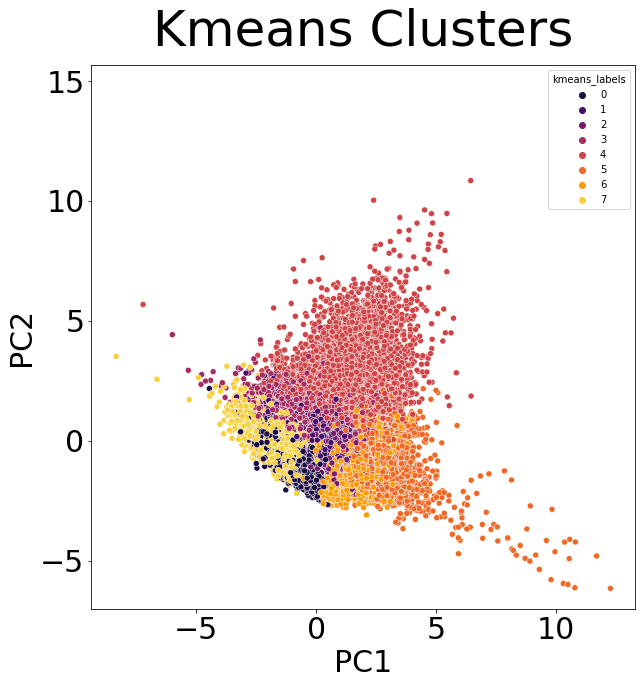

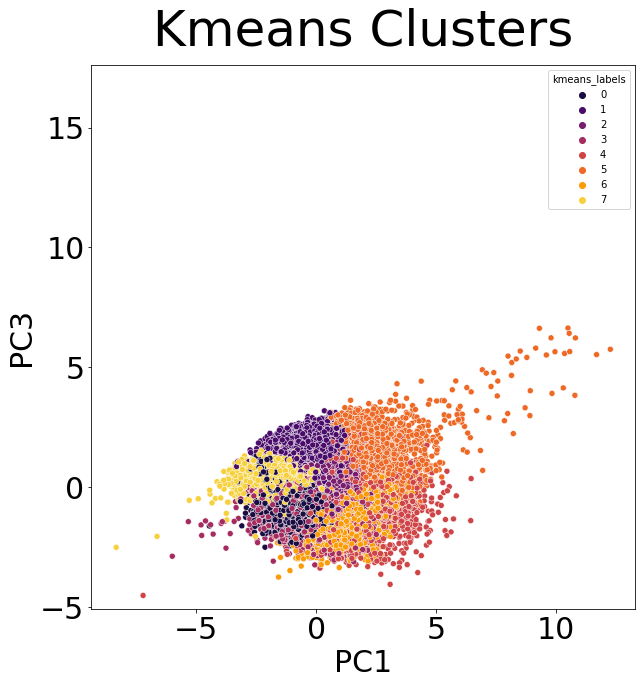

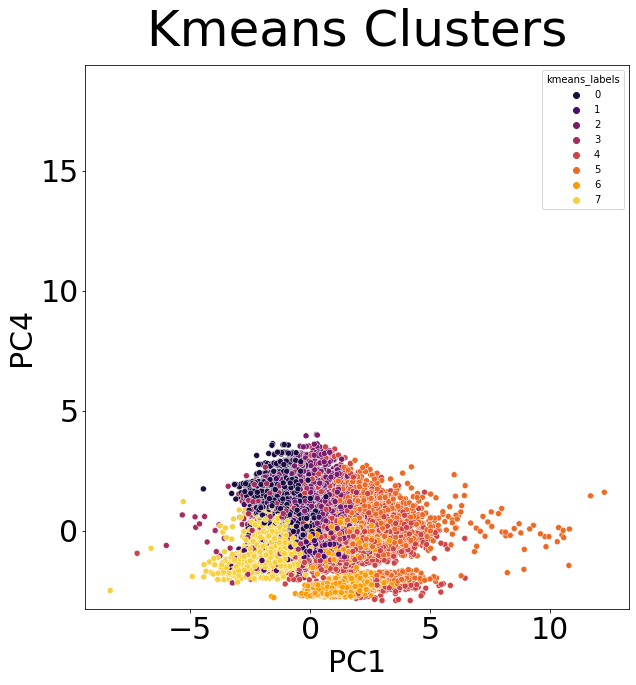

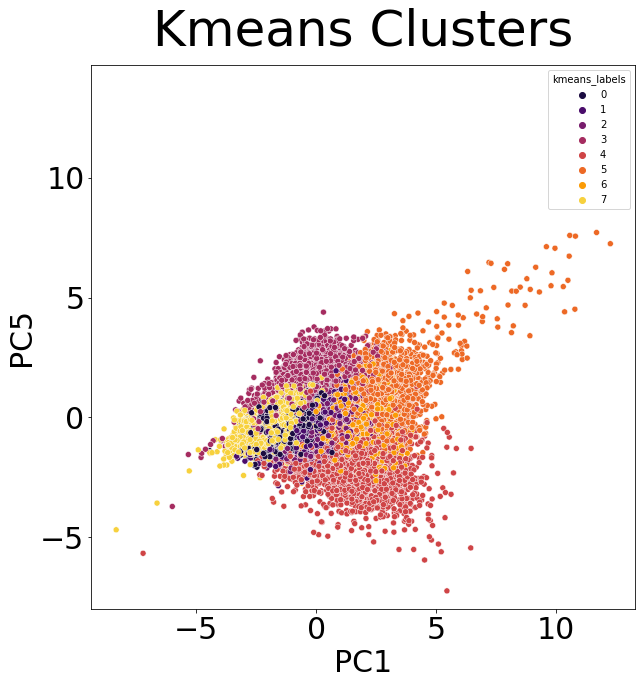

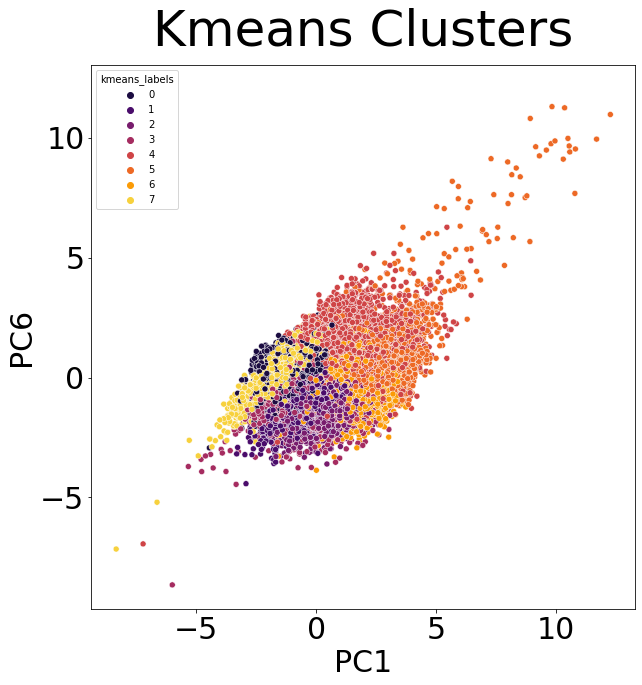

In [25]:
# Plots PCA projections with clusters hued

plot_pca_projected(X_std_pca_projected[components_name + ['kmeans_labels']],
                   'PC1',
                   'PC2',
                   'Kmeans',
                   'kmeans_labels',
                   palette_max_8)

plot_pca_projected(X_std_pca_projected[components_name + ['kmeans_labels']],
                   'PC1',
                   'PC3',
                   'Kmeans',
                   'kmeans_labels',
                   palette_max_8)

plot_pca_projected(X_std_pca_projected[components_name + ['kmeans_labels']],
                   'PC1',
                   'PC4',
                   'Kmeans',
                   'kmeans_labels',
                   palette_max_8)

plot_pca_projected(X_std_pca_projected[components_name + ['kmeans_labels']],
                   'PC1',
                   'PC5',
                   'Kmeans',
                   'kmeans_labels',
                   palette_max_8)

plot_pca_projected(X_std_pca_projected[components_name + ['kmeans_labels']],
                   'PC1',
                   'PC6',
                   'Kmeans',
                   'kmeans_labels',
                   palette_max_8)


In [26]:
(X_std['kmeans_labels'].value_counts()/X_std.shape[0])\
    .mul(100)\
    .to_frame(name='Cluster Size (%)')\
    .reset_index()\
    .rename({'index': 'Cluster'}, axis=1)\
    .style.hide(axis='index')


<center><h6>Kmeans interpretation

In [27]:
# Creates a dataframe for interpretation and possible marketing
# actionability

interpretation = {
    'Cluster': [2, 0, 4, 3, 1, 7, 5, 6],
    'Recency': ['★★★★★',
                '★★★★★',
                '★★★☆☆',
                '★★★★☆',
                '★☆☆☆☆',
                '★☆☆☆☆',
                '★★★☆☆',
                '★★★★☆'],
    'Monetary_Mean': ['★★★☆☆',
                      '★★★☆☆',
                      '★★★★☆',
                      '★★★★★',
                      '★★★☆☆',
                      '★★★☆☆',
                      '★★★☆☆',
                      '★★★☆☆'],
    'Satisfaction': ['★☆☆☆☆',
                     '★★★★★',
                     '★★★☆☆',
                     '★★★★☆',
                     '★☆☆☆☆',
                     '★★★★★',
                     '★☆☆☆☆',
                     '★★★☆☆'],
    'Timing': ['★★★☆☆',
               '★★★☆☆',
               '★★★☆☆',
               '★★★☆☆',
               '★★★☆☆',
               '★★★☆☆',
               '★☆☆☆☆',
               '★★★☆☆'],
    'Basket': ['★★★☆☆',
               '★★★☆☆',
               '★★★★★',
               '★★★☆☆',
               '★★★☆☆',
               '★★★☆☆',
               '★★★☆☆',
               '★★★☆☆'],
    'Event': ['★★★☆☆',
              '★★★☆☆',
              '★★★☆☆',
              '★★★☆☆',
              '★★★☆☆',
              '★★★☆☆',
              '★★★☆☆',
              '★★★★★']}

catchphrases = [
    'I recently have been disappointed and this isn\'t related to '
    + 'the delivery !',
    'I recently have been satisfied ! ',
    'I like to buy several items at once !',
    'I buy expensive items and this isn\'t due to my basket !',
    'I have been disappointed some time ago and this wasn\'t'
    + ' related to the delivery !',
    'I have been satisfied a long time ago !',
    'I am very disappointed by the delivery service !',
    'I like events !']

marketing_operation = [
    'Recovery/Apology/Crisis/Empathical Campaign',
    'Loyalty Building Campaign',
    'Promotional Campaign/If more items Then gains Campaign',
    'Low frequency expansive suggestions/Reduction '
    + '(on / if) high product range',
    'Redemption Campaign/We have changed since'
    + ' give our progresses a try !',
    'Check up Campaign/How are you doing since ? '
    + 'How can we help you now ?',
    'Redemption Campaign with a focus on the delivery time',
    'Event Campaign (Christmas,Black Friday, etc.)']


interpretation_df = pd.DataFrame(interpretation)

interpretation_df['Catchphrase'] = catchphrases
interpretation_df['Marketing Operation Example'] = marketing_operation

with pd.option_context('display.max_colwidth', None):
    interpretation_df


Cluster Recency Monetary_Mean Satisfaction Timing Basket  Event  \
0        2   ★★★★★         ★★★☆☆        ★☆☆☆☆  ★★★☆☆  ★★★☆☆  ★★★☆☆   
1        0   ★★★★★         ★★★☆☆        ★★★★★  ★★★☆☆  ★★★☆☆  ★★★☆☆   
2        4   ★★★☆☆         ★★★★☆        ★★★☆☆  ★★★☆☆  ★★★★★  ★★★☆☆   
3        3   ★★★★☆         ★★★★★        ★★★★☆  ★★★☆☆  ★★★☆☆  ★★★☆☆   
4        1   ★☆☆☆☆         ★★★☆☆        ★☆☆☆☆  ★★★☆☆  ★★★☆☆  ★★★☆☆   
5        7   ★☆☆☆☆         ★★★☆☆        ★★★★★  ★★★☆☆  ★★★☆☆  ★★★☆☆   
6        5   ★★★☆☆         ★★★☆☆        ★☆☆☆☆  ★☆☆☆☆  ★★★☆☆  ★★★☆☆   
7        6   ★★★★☆         ★★★☆☆        ★★★☆☆  ★★★☆☆  ★★★☆☆  ★★★★★   

                                                                        Catchphrase  \
0        I recently have been disappointed and this isn't related to the delivery !   
1                                                 I recently have been satisfied !    
2                                             I like to buy several items at once !   
3                           I buy expensive items and this isn't due to my basket !   
4  I have been disappointed some time ago and this wasn't related to the delivery !   
5                                           I have been satisfied a long time ago !   
6                                  I am very disappointed by the delivery service !   
7                                                                   I like events !   

                                                  Marketing Operation Example  
0                                 Recovery/Apology/Crisis/Empathical Campaign  
1                                                   Loyalty Building Campaign  
2                      Promotional Campaign/If more items Then gains Campaign  
3  Low frequency expansive suggestions/Reduction (on / if) high product range  
4       Redemption Campaign/We have changed since give our progresses a try !  
5       Check up Campaign/How are you doing since ? How can we help you now ?  
6                       Redemption Campaign with a focus on the delivery time  
7                               Event Campaign (Christmas,Black Friday, etc.)

<center><h3>Other Models (not chosen)

In [28]:
# Creates an empty dataframe for computation logs

dbscan_scores_df = pd.DataFrame(data=[])

dbscan_grid = [{'eps': [0.5, 1],
               'min_samples': [50, 100]}]

# Computes DBSCAN sihlouette score and fit time according to
# different combinaison of parameters (outputed)
# NB : The number of clusters found by the DBSCAN is also retrieved

for i, params in enumerate(ParameterGrid(dbscan_grid)):

    dbscan = DBSCAN()

    dbscan.set_params(**params)

    dbscan_scores_df.loc[i, 'eps'] = params['eps']
    dbscan_scores_df.loc[i, 'min_samples'] = params['min_samples']

    t0 = time.time()

    dbscan_fitted = dbscan.fit(X_std[rms_tae_columns])

    fit_time = time.time() - t0

    dbscan_scores_df.loc[i, 'clusters'] = \
        len(np.unique(dbscan_fitted.labels_))

    dbscan_scores_df.loc[i, 'silhouette'] = \
        silhouette_score(X_std, dbscan_fitted.labels_)

    dbscan_scores_df.loc[i, 'fit_time'] = fit_time


DBSCAN(min_samples=50)

DBSCAN(min_samples=100)

DBSCAN(eps=1, min_samples=50)

DBSCAN(eps=1, min_samples=100)

In [29]:
# Analyses the clusters when they are in the [3;9] range (for actionability)

dbscan_scores_df[(dbscan_scores_df['clusters'] > 2)
                 & (dbscan_scores_df['clusters'] < 10)]\
    .style\
    .highlight_max(subset=['silhouette'], color='#fbb61a')\
    .highlight_min(subset=['fit_time'], color='#fbb61a')


# Displays the chosen cluster number, silhouette and
# fit_time relation for DBSCAN

dbscan_scores_df.loc[[2]]


eps  min_samples  clusters  silhouette   fit_time
2  1.0         50.0       7.0   -0.003296  52.614974

In [30]:
# Fit the chosen params

dbscan_3 = DBSCAN(eps=1, min_samples=50).fit(X_std[rms_tae_columns])

X_std['dbscan_labels'] = dbscan_3.labels_

# Changes -1 labels in max + 1 for easiness of use

X_std['dbscan_labels'] = \
    X_std['dbscan_labels']\
    .apply(lambda x: X_std['dbscan_labels'].max() + 1 if x == -1 else x)

X_std_pca_projected['dbscan_labels'] = X_std['dbscan_labels'].values


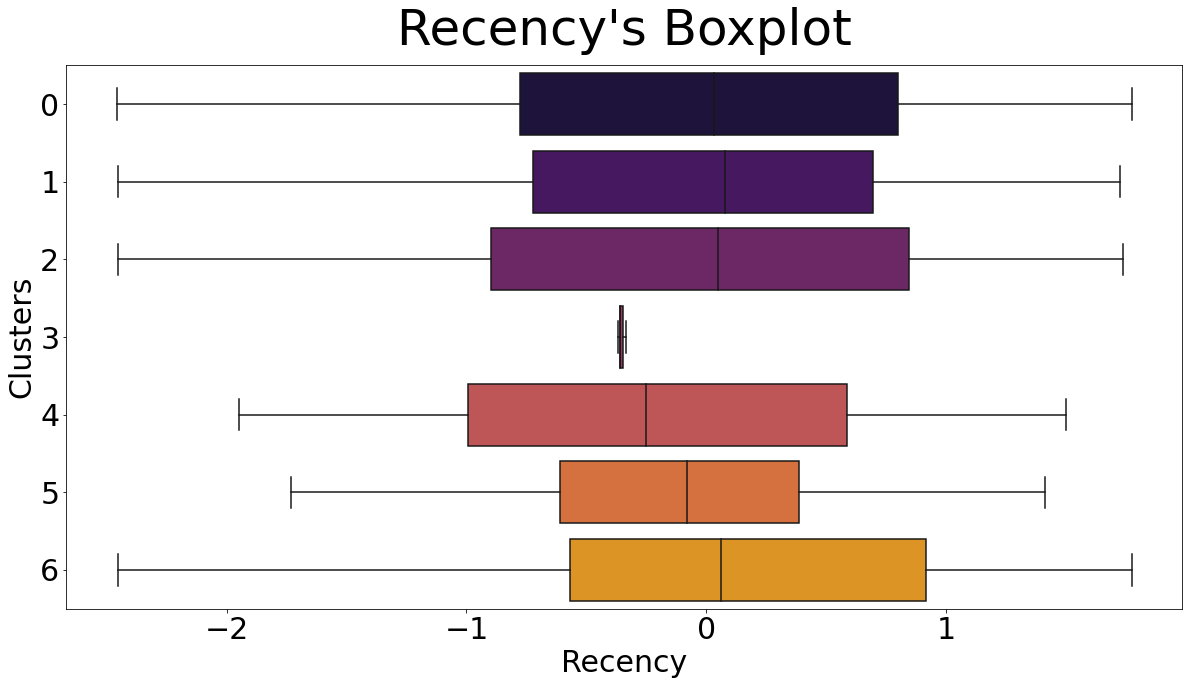

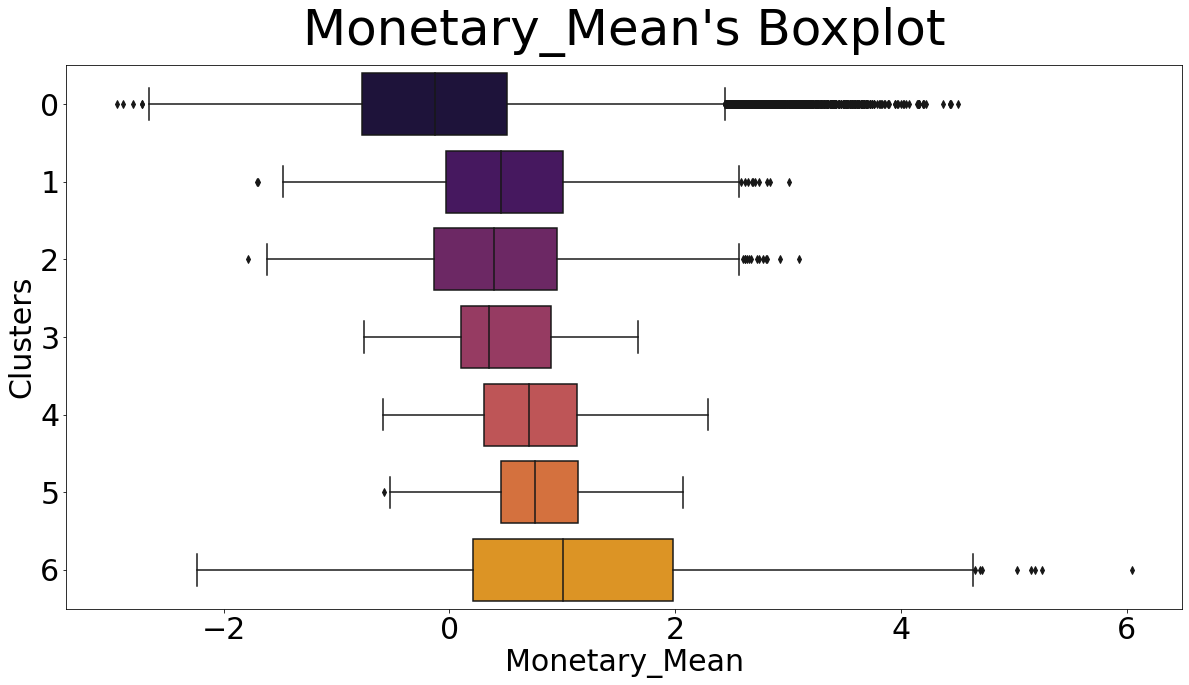

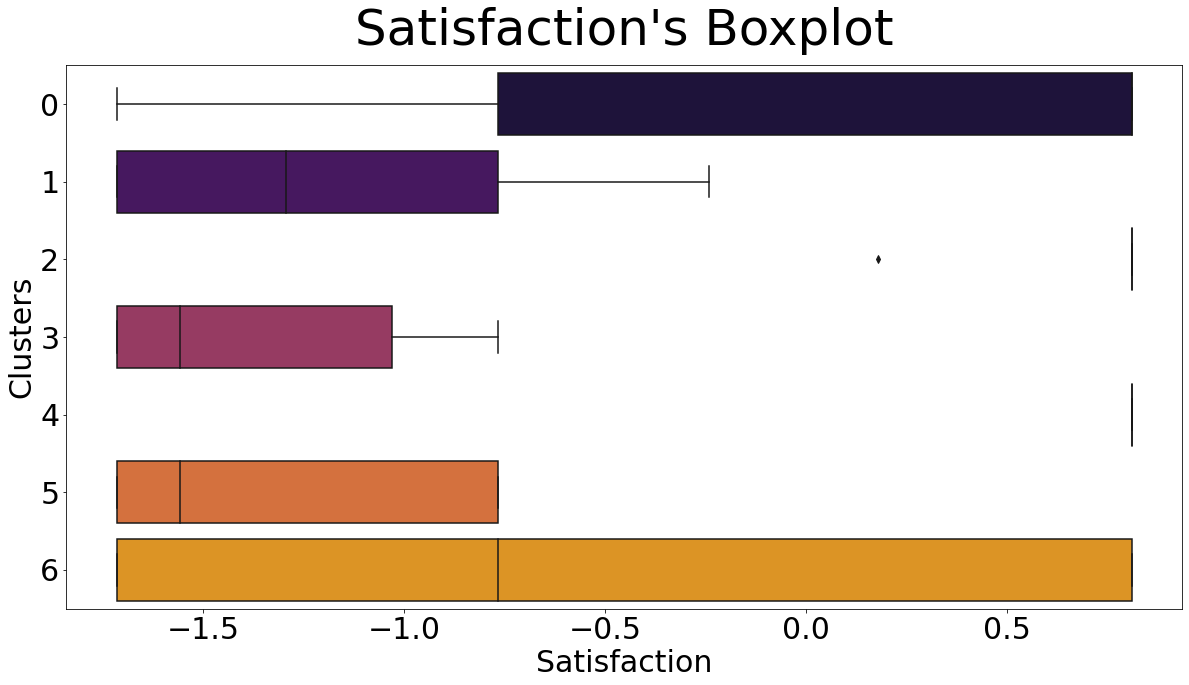

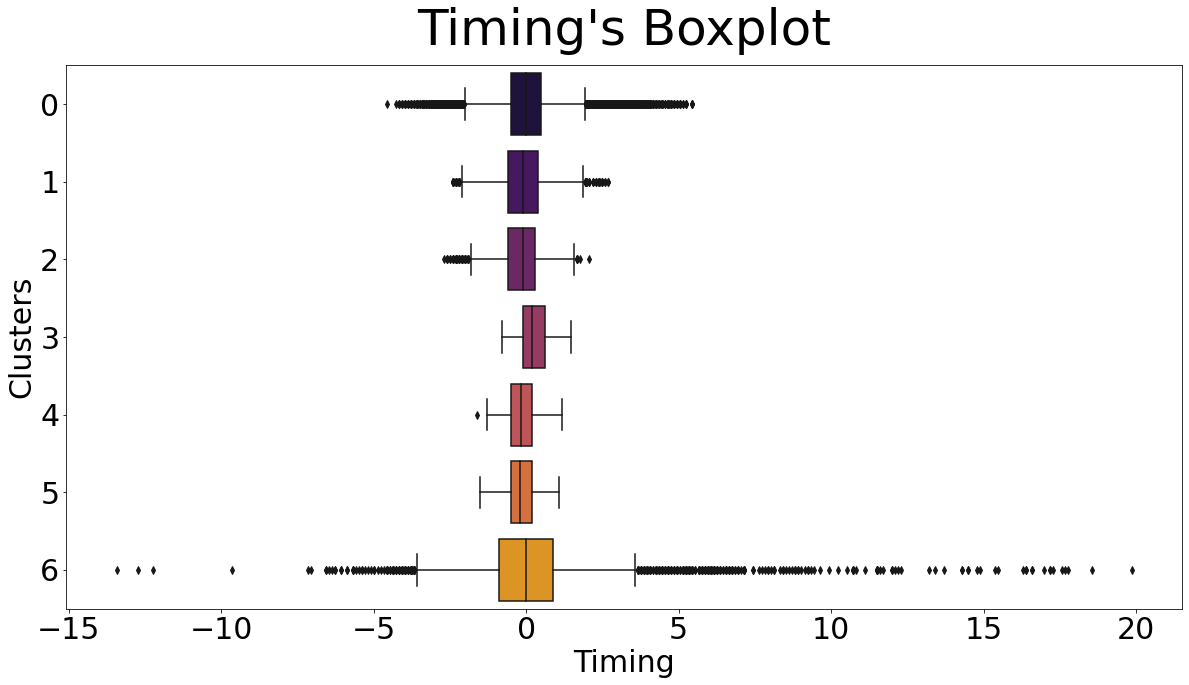

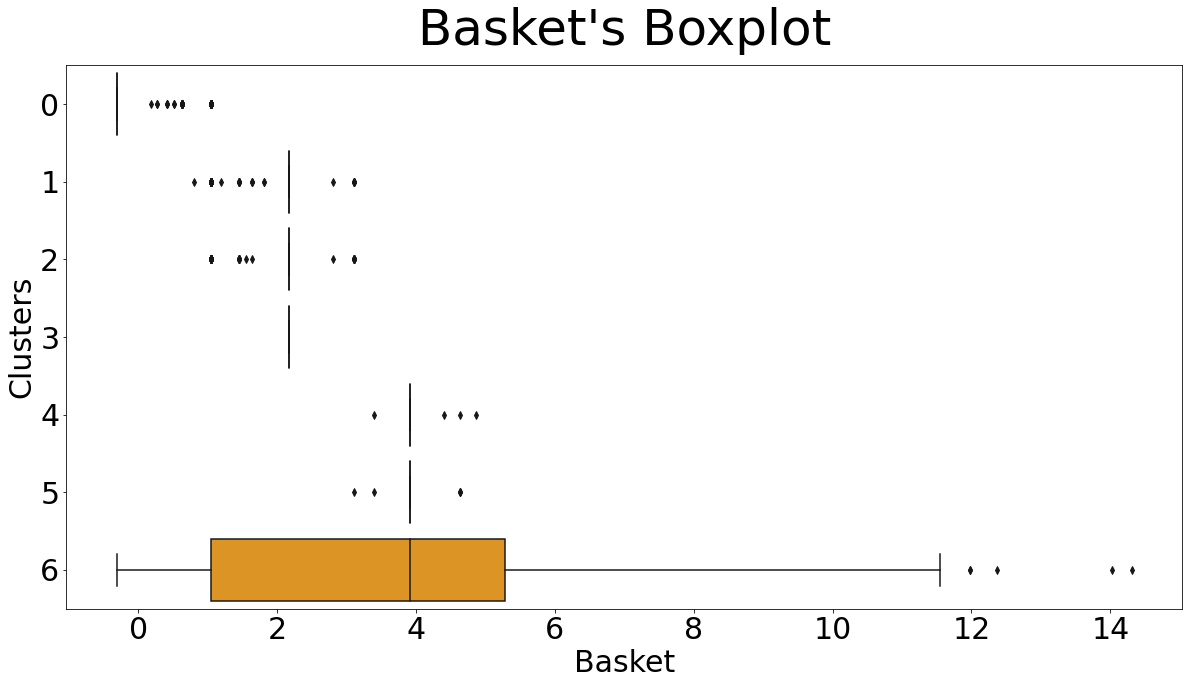

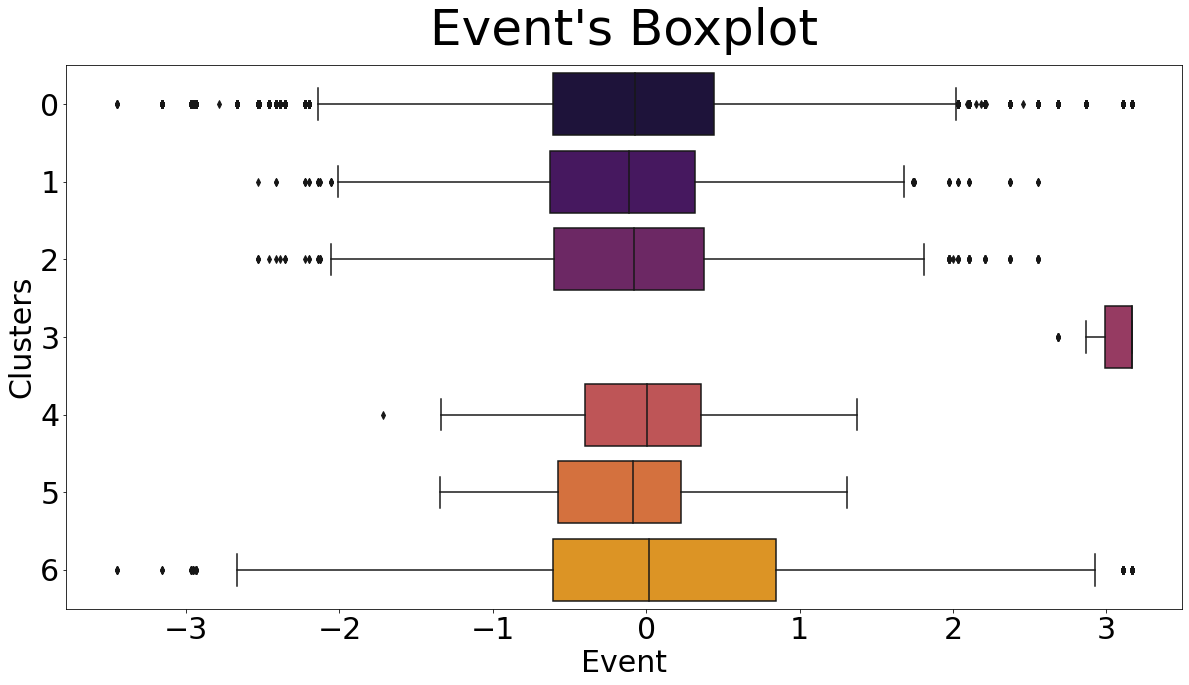

In [31]:
# Plots cluster's boxplots

for i in rms_tae_columns:
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.boxplot(data=X_std[rms_tae_columns + ['dbscan_labels']],
                x=i,
                y='dbscan_labels',
                palette=palette_max_8,
                orient="h",
                ax=ax)
    ax.tick_params(labelsize=tick_size)
    ax.set_xlabel('{}'.format(i), fontsize=text_size)
    ax.set_ylabel('Clusters', fontsize=text_size)
    plt.title('{}\'s Boxplot'.format(i), pad=20, fontsize=title_size)
plt.show();


* [Anchor to PCA Circles](#PCA_Circles)


<p class="anchor" id="PCA_DBSCAN"></p>

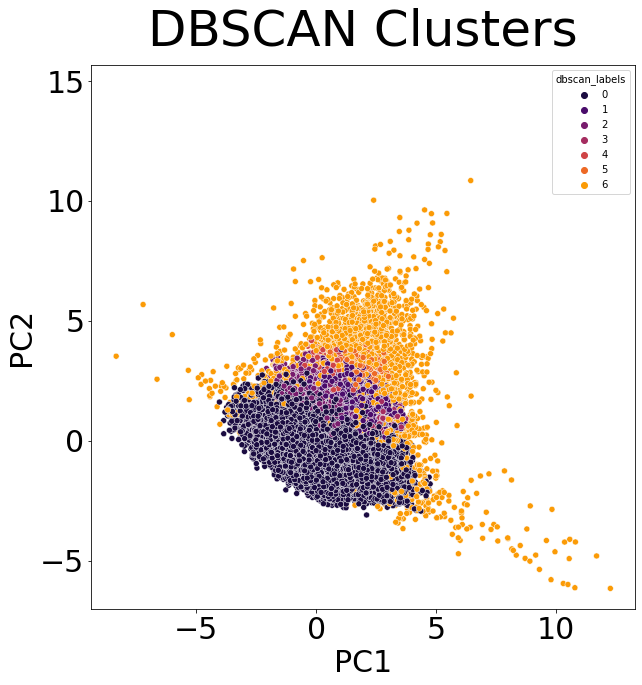

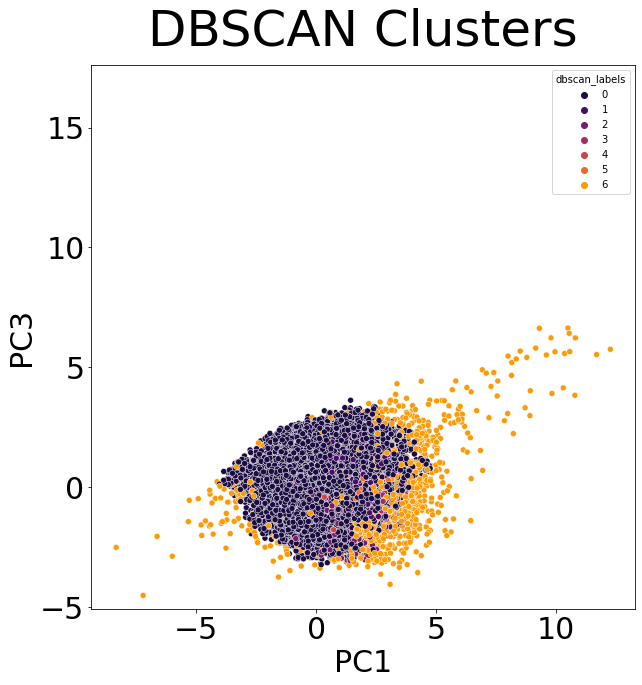

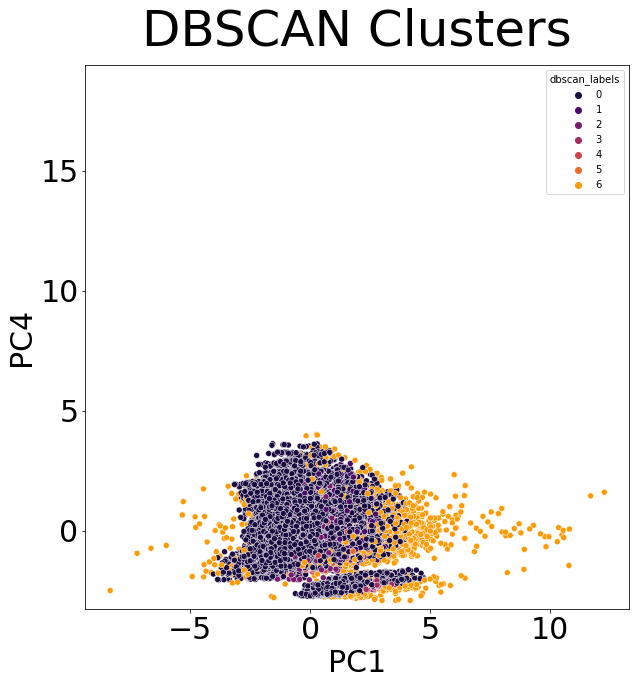

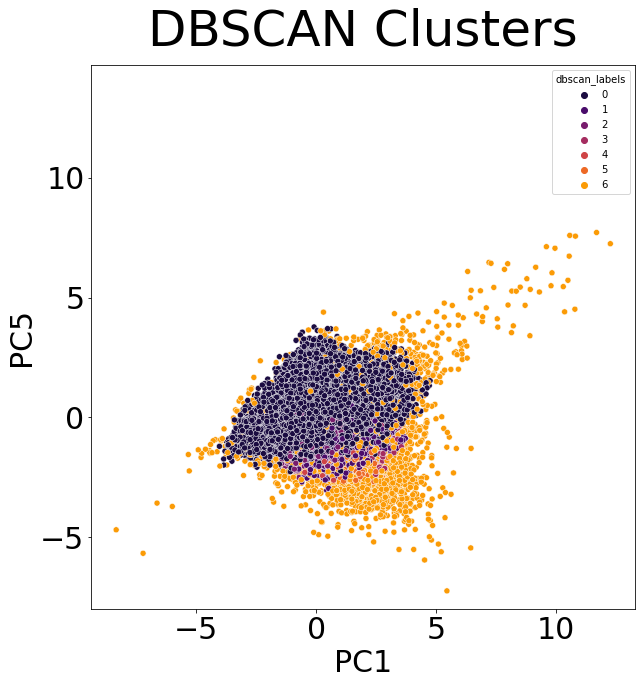

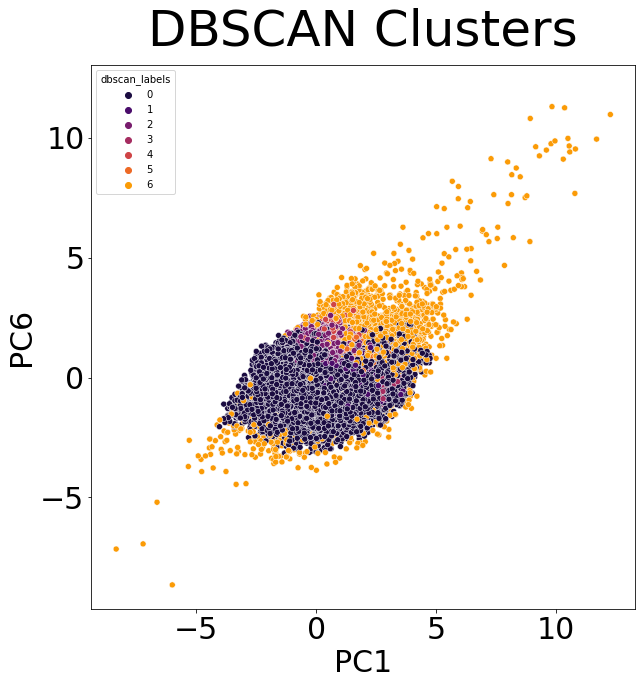

In [32]:
# Plots PCA projections with clusters hued

plot_pca_projected(X_std_pca_projected[components_name + ['dbscan_labels']],
                   'PC1',
                   'PC2',
                   'DBSCAN',
                   'dbscan_labels',
                   palette_max_8)

plot_pca_projected(X_std_pca_projected[components_name + ['dbscan_labels']],
                   'PC1',
                   'PC3',
                   'DBSCAN',
                   'dbscan_labels',
                   palette_max_8)

plot_pca_projected(X_std_pca_projected[components_name + ['dbscan_labels']],
                   'PC1',
                   'PC4',
                   'DBSCAN',
                   'dbscan_labels',
                   palette_max_8)

plot_pca_projected(X_std_pca_projected[components_name + ['dbscan_labels']],
                   'PC1',
                   'PC5',
                   'DBSCAN',
                   'dbscan_labels',
                   palette_max_8)

plot_pca_projected(X_std_pca_projected[components_name + ['dbscan_labels']],
                   'PC1',
                   'PC6',
                   'DBSCAN',
                   'dbscan_labels',
                   palette_max_8)


In [33]:
(X_std['dbscan_labels'].value_counts()/X_std.shape[0])\
    .mul(100)\
    .to_frame(name='Cluster Size (%)')\
    .reset_index()\
    .rename({'index': 'Cluster'}, axis=1)\
    .style.hide(axis='index')


<center><h3>Hierarchical Clustering

In [34]:
# Put a cutoff for aglomerative clustering as it is time consuming in a
# new dataframe (X_std_agglomerative_clustering)

agglomerative_clustering_cutoff = 10000

X_std_agglomerative_clustering = \
    X_std.iloc[:agglomerative_clustering_cutoff].copy()

# Creates an empty dataframe for computation logs

agglomerative_clustering_df = pd.DataFrame(data=[])

# Computes the silhouette score and the fit-time for clusters
# in the range [3;9]

for i in range(3, 10):

    t0 = time.time()

    agglomerative_clustering = \
        AgglomerativeClustering(n_clusters=i)\
        .fit(X_std_agglomerative_clustering[rms_tae_columns])

    fit_time = time.time() - t0

    # Commits params and scores in agglomerative_clustering_df

    agglomerative_clustering_df.loc[i, 'clusters'] = i

    agglomerative_clustering_df.loc[i, 'silhouette'] = \
        silhouette_score(X_std_agglomerative_clustering,
                         agglomerative_clustering.labels_)

    agglomerative_clustering_df.loc[i, 'fit_time'] = fit_time


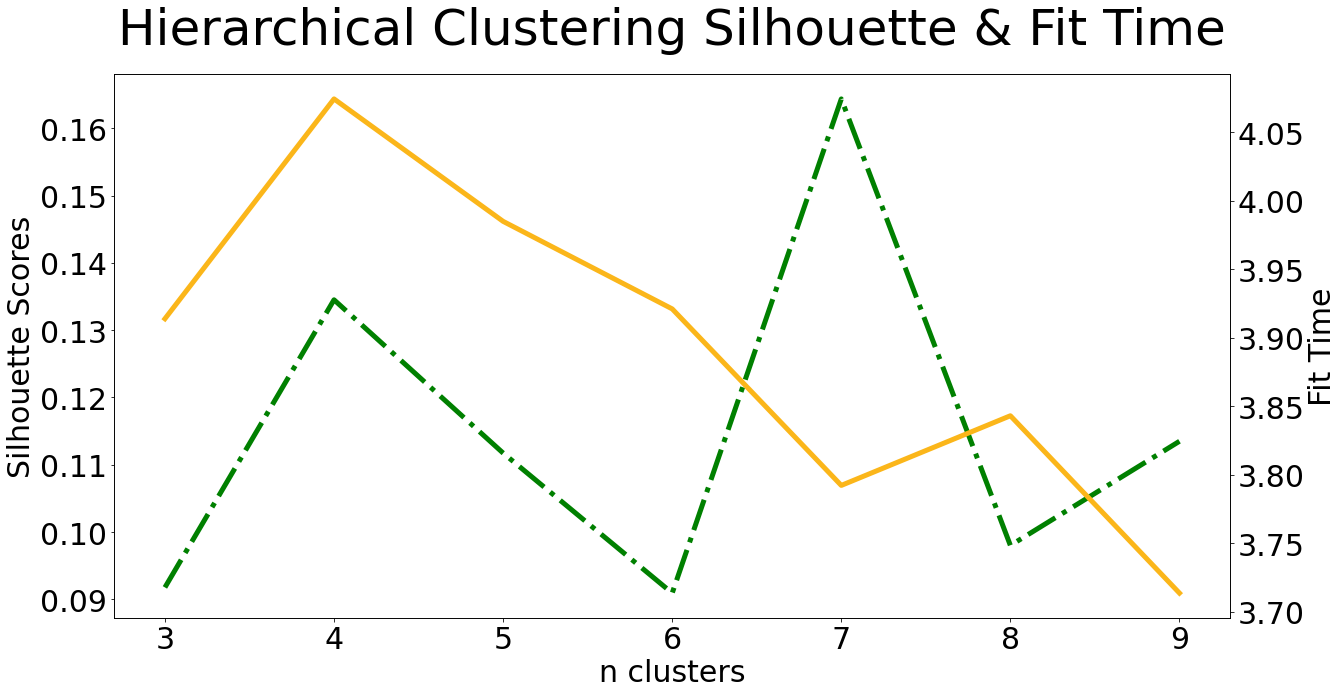

In [35]:
# Silhouette & Fit time plots

fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

sns.lineplot(data=agglomerative_clustering_df,
             x='clusters',
             y='silhouette',
             lw=5,
             color=sns.color_palette('inferno', 5)[4],
             ax=ax1)

sns.lineplot(data=agglomerative_clustering_df,
             x='clusters',
             y='fit_time',
             lw=5,
             color='green',
             ax=ax2,
             ls='dashdot')

ax1.set_zorder(1)
ax1.patch.set_visible(False)
ax1.tick_params(labelsize=tick_size)
ax1.set_xlabel('n clusters', fontsize=text_size)
ax1.set_ylabel('Silhouette Scores', fontsize=text_size)
ax2.tick_params(labelsize=tick_size)
ax2.set_ylabel('Fit Time', fontsize=text_size)

plt.title('Hierarchical Clustering Silhouette & Fit Time',
          fontsize=title_size, pad=30)

plt.show();


In [36]:
# Fits a hierarchical clustering with 4 clusters

agglomerative_clustering_4 = \
    AgglomerativeClustering(n_clusters=4)\
    .fit(X_std_agglomerative_clustering[rms_tae_columns])

X_std_agglomerative_clustering['agglomerative_clustering_labels'] = \
    agglomerative_clustering_4.labels_

# Adapts the PCA projection to the cutoff for agglomerative clustering

X_std_pca_projected.loc[:agglomerative_clustering_cutoff - 1,
                        'agglomerative_clustering_labels'] = \
    agglomerative_clustering_4.labels_


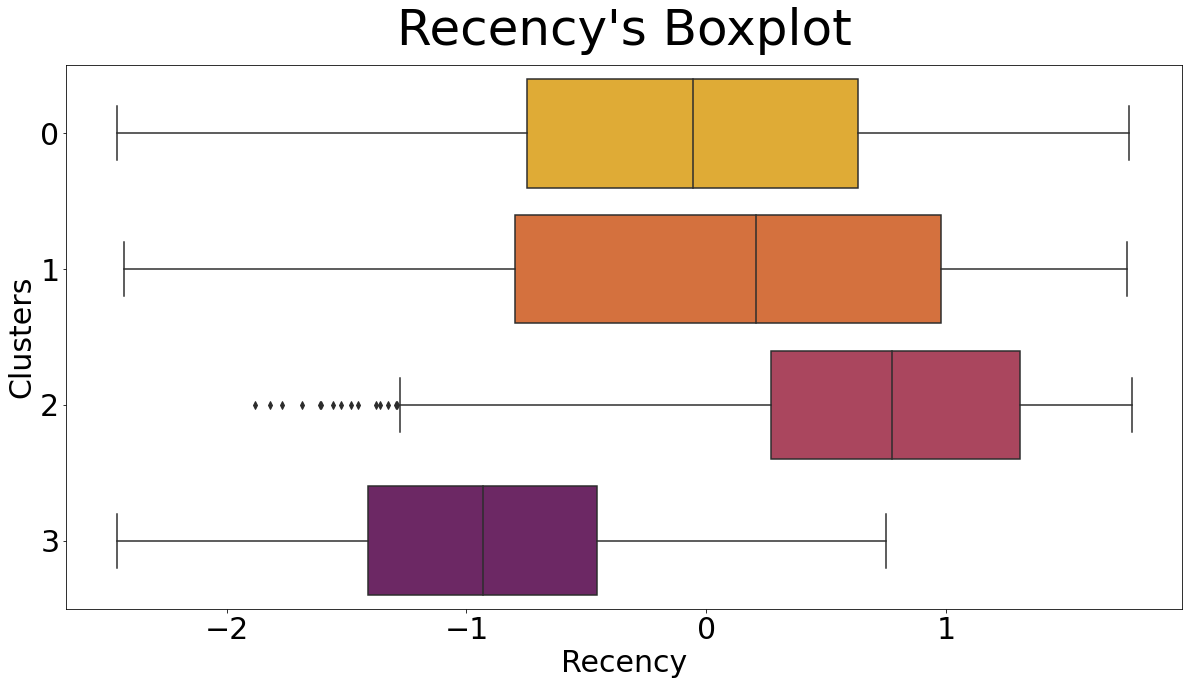

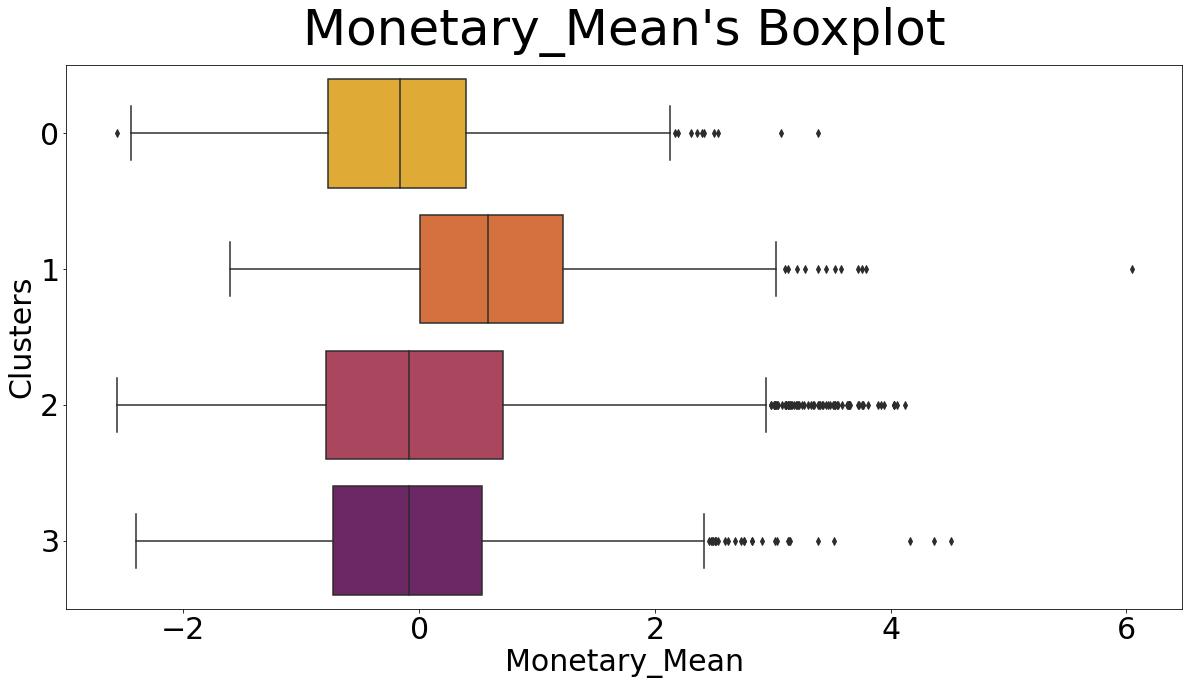

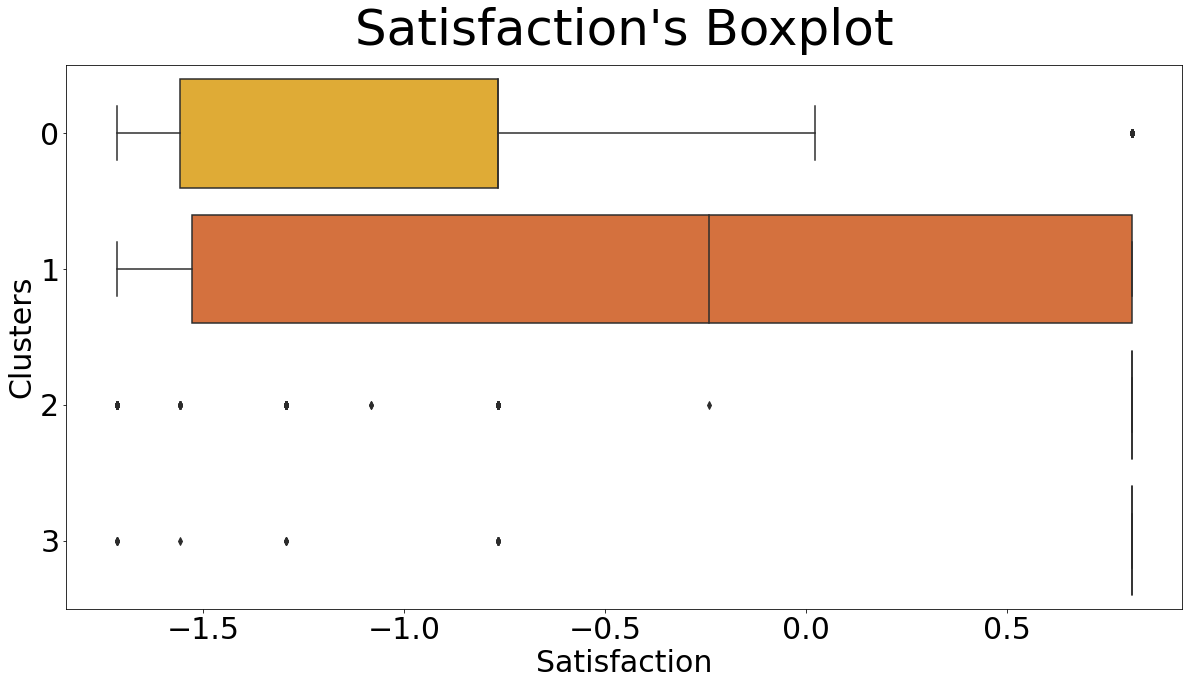

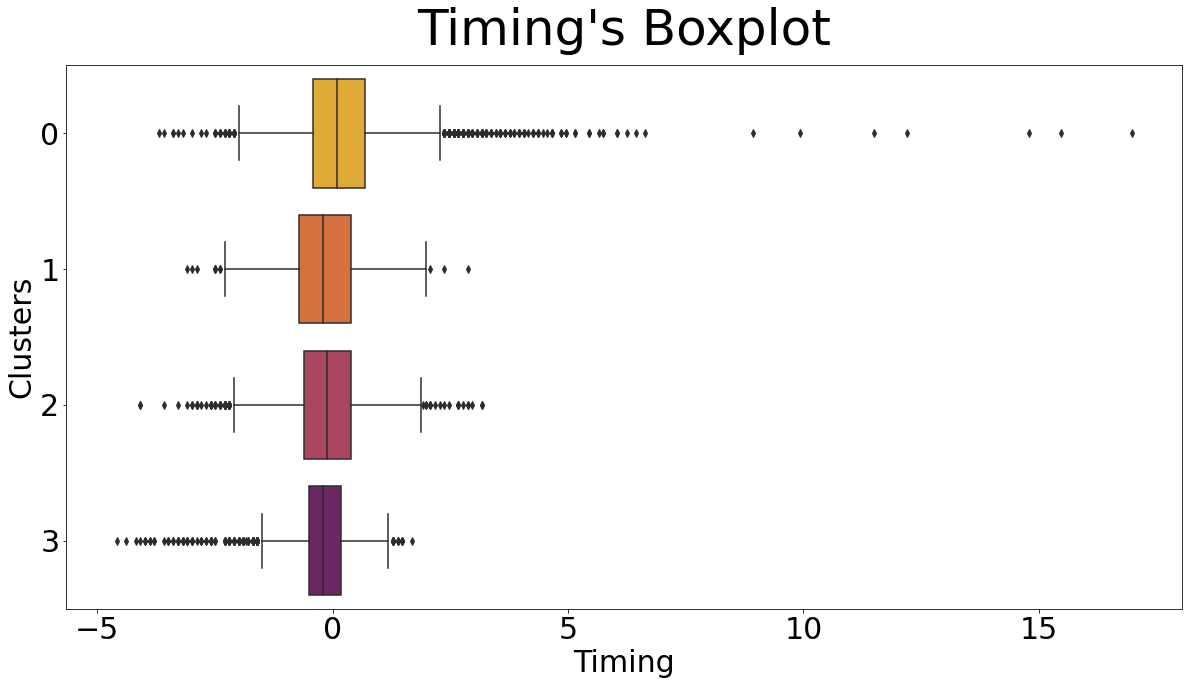

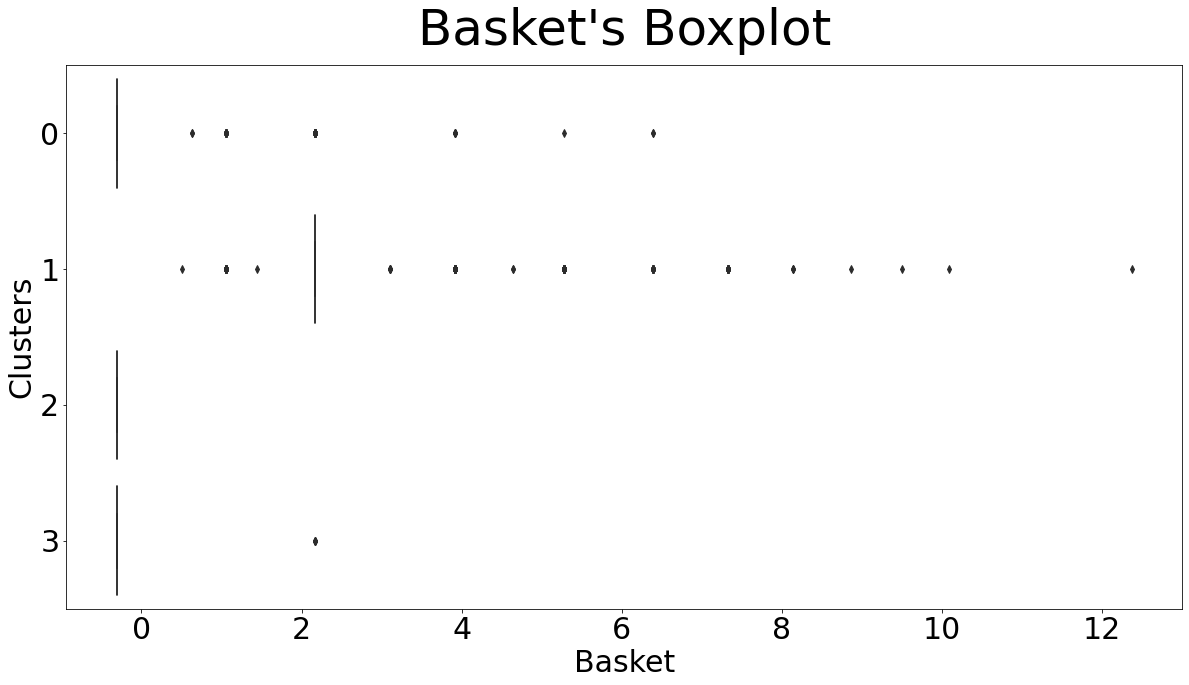

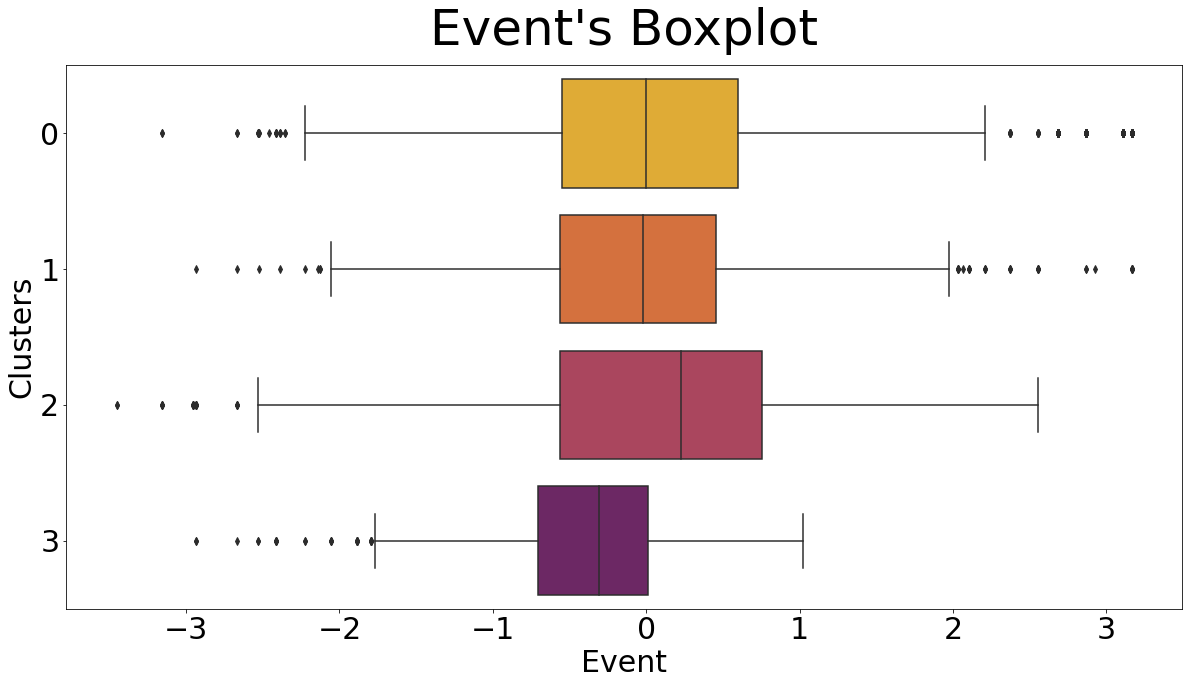

In [37]:
# Plots cluster's boxplots

for i in rms_tae_columns:
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.boxplot(data=X_std_agglomerative_clustering[
                     rms_tae_columns + ['agglomerative_clustering_labels']],
                x=i,
                y='agglomerative_clustering_labels',
                palette=palette_max_5,
                orient="h",
                ax=ax)
    ax.tick_params(labelsize=tick_size)
    ax.set_xlabel('{}'.format(i), fontsize=text_size)
    ax.set_ylabel('Clusters', fontsize=text_size)
    plt.title('{}\'s Boxplot'.format(i), pad=20, fontsize=title_size)
plt.show();


* [Anchor to PCA Circles](#PCA_Circles)


<p class="anchor" id="PCA_hierarchical"></p>

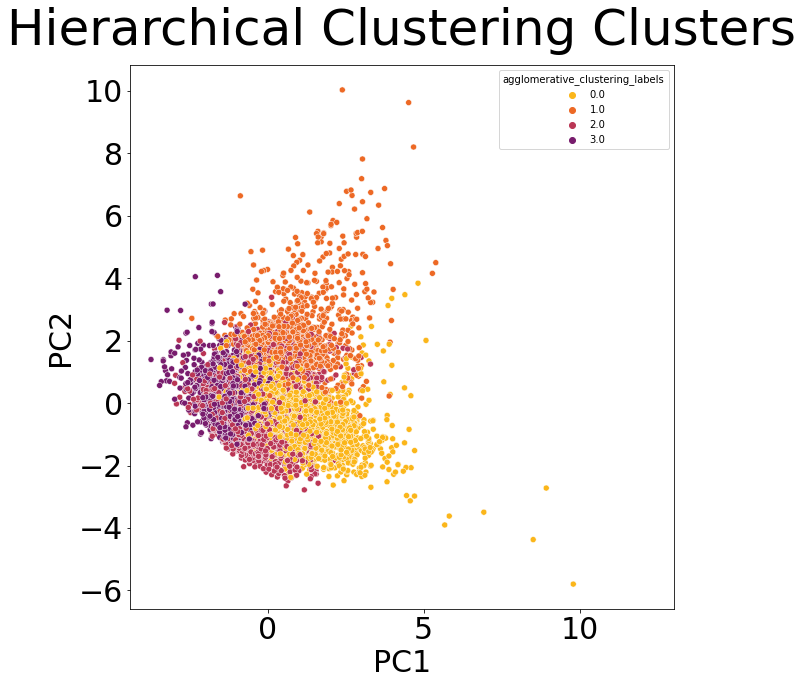

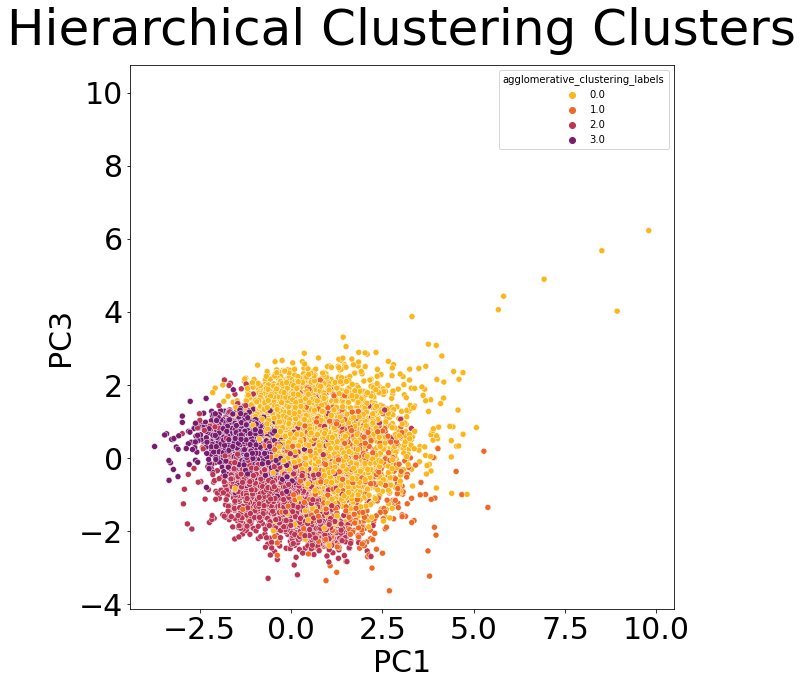

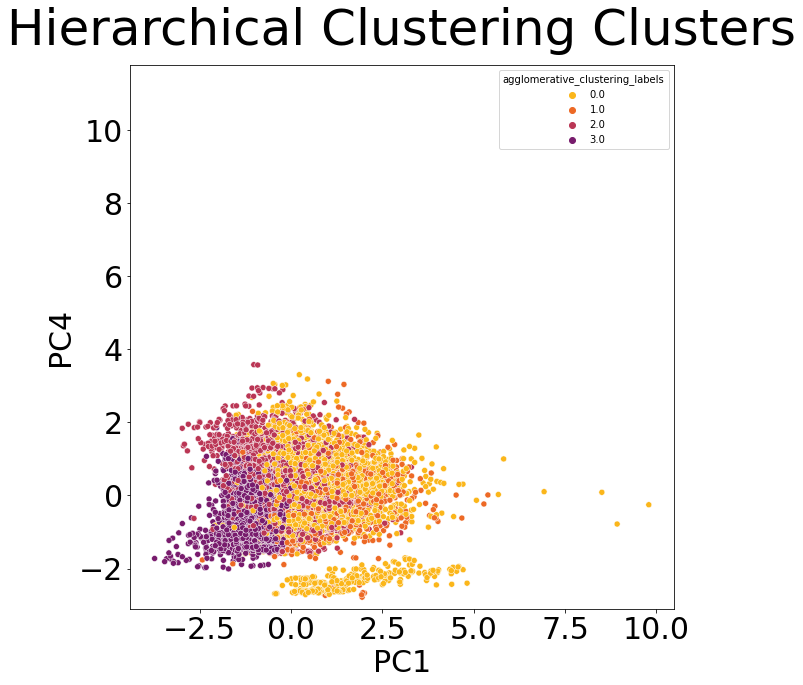

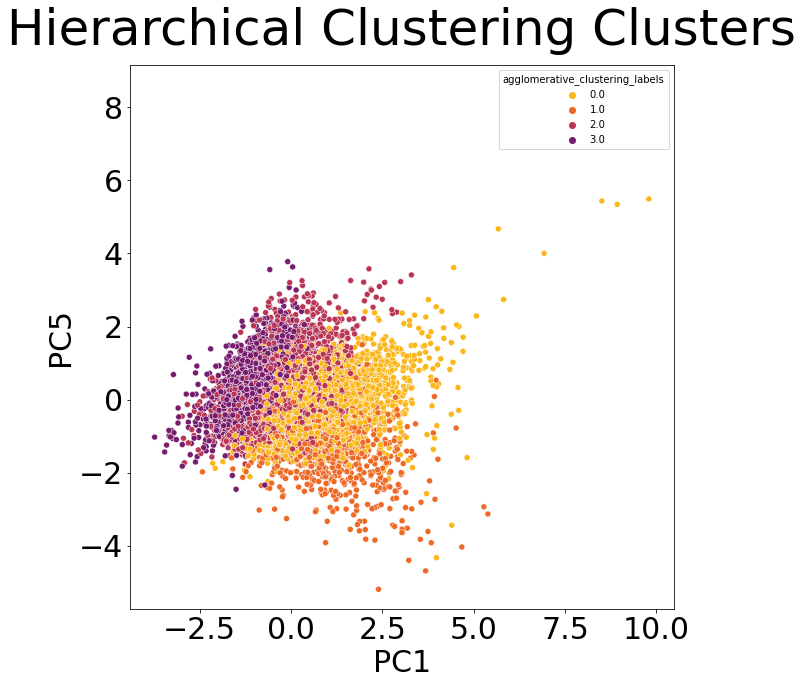

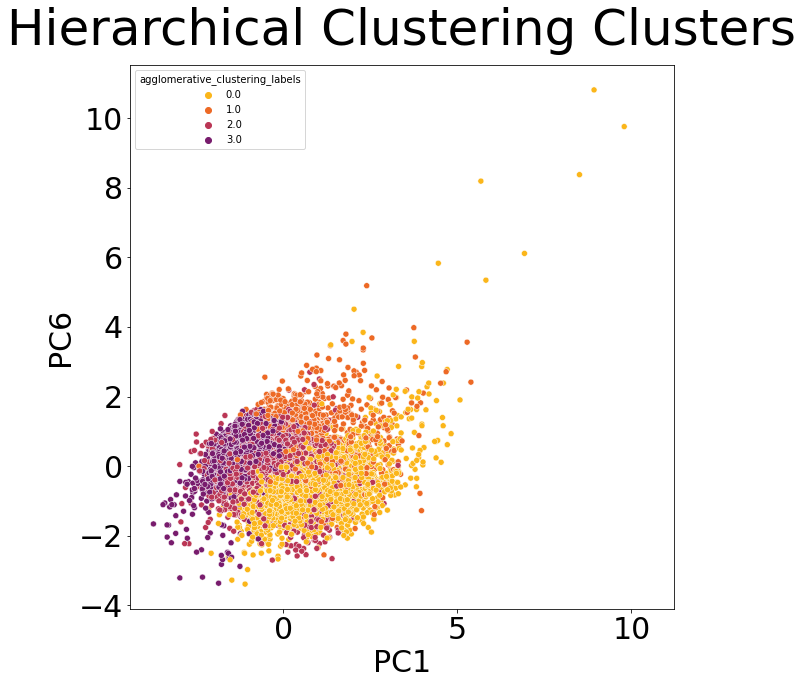

In [38]:
# Plots PCA projections with clusters hued

plot_pca_projected(X_std_pca_projected
                   .loc[:agglomerative_clustering_cutoff,
                        components_name
                        + ['agglomerative_clustering_labels']],
                   'PC1',
                   'PC2',
                   'Hierarchical Clustering',
                   'agglomerative_clustering_labels',
                   palette_max_5)

plot_pca_projected(X_std_pca_projected
                   .loc[:agglomerative_clustering_cutoff,
                        components_name
                        + ['agglomerative_clustering_labels']],
                   'PC1',
                   'PC3',
                   'Hierarchical Clustering',
                   'agglomerative_clustering_labels',
                   palette_max_5)

plot_pca_projected(X_std_pca_projected
                   .loc[:agglomerative_clustering_cutoff,
                        components_name
                        + ['agglomerative_clustering_labels']],
                   'PC1',
                   'PC4',
                   'Hierarchical Clustering',
                   'agglomerative_clustering_labels',
                   palette_max_5)

plot_pca_projected(X_std_pca_projected
                   .loc[:agglomerative_clustering_cutoff,
                        components_name
                        + ['agglomerative_clustering_labels']],
                   'PC1',
                   'PC5',
                   'Hierarchical Clustering',
                   'agglomerative_clustering_labels',
                   palette_max_5)

plot_pca_projected(X_std_pca_projected
                   .loc[:agglomerative_clustering_cutoff,
                        components_name
                        + ['agglomerative_clustering_labels']],
                   'PC1',
                   'PC6',
                   'Hierarchical Clustering',
                   'agglomerative_clustering_labels',
                   palette_max_5)


In [39]:
(X_std_agglomerative_clustering['agglomerative_clustering_labels']
    .value_counts()/X_std_agglomerative_clustering.shape[0])\
    .mul(100)\
    .to_frame(name='Cluster Size (%)')\
    .reset_index()\
    .rename({'index': 'Cluster'}, axis=1)\
    .style.hide(axis='index')
